<a href="https://colab.research.google.com/github/read-project/machine-learning-models/blob/main/Draw/Draw_Classif_NN_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TODO


1. Verificare perche'f1 score su testset da risultati diversi
2. Integrare wandb
5. Docker errore np.bool

## Common Setup

In [ ]:
#!pip install imgaug
!pip install git+https://github.com/aleju/imgaug.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/aleju/imgaug.git to /tmp/pip-req-build-1qh17j3o
  Running command git clone --filter=blob:none --quiet https://github.com/aleju/imgaug.git /tmp/pip-req-build-1qh17j3o
  Resolved https://github.com/aleju/imgaug.git to commit 0101108d4fed06bc5056c4a03e2bcb0216dac326
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import backend as K
import pathlib
from matplotlib import pyplot as plt

from tensorflow.keras.applications import ResNet50, VGG16

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from collections import Counter

import imageio

from keras.utils.vis_utils import plot_model

from tensorboard.plugins import projector
import cv2
import shutil
import sklearn

import imgaug as ia
import imgaug.augmenters as iaa
import json
from PIL import Image
import pickle
import gc
from keras.callbacks import TensorBoard
from imblearn.over_sampling import RandomOverSampler
import random
from sklearn.model_selection import train_test_split
import csv
from sklearn.metrics import roc_curve,precision_recall_curve

In [ ]:
!pip list | grep tensorflow

tensorflow                    2.12.0
tensorflow-datasets           4.9.2
tensorflow-estimator          2.12.0
tensorflow-gcs-config         2.12.0
tensorflow-hub                0.13.0
tensorflow-io-gcs-filesystem  0.32.0
tensorflow-metadata           1.13.1
tensorflow-probability        0.20.1


In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 18.3 MB/s eta 0:00:00


In [ ]:
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.7/206.7 kB 22.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.9 MB/s eta 0:00:00


In [ ]:
from tensorflow_addons.optimizers import AdamW
from operator import is_
from sklearn.metrics import multilabel_confusion_matrix
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from numpy import mean
from numpy import std
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.multioutput import MultiOutputClassifier
from scikeras.wrappers import KerasClassifier
# optimization method
from keras.optimizers import SGD
import csv
from sklearn import metrics

# Weights and Biases related imports
import wandb
from wandb.keras import WandbMetricsLogger

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


# Init

In [ ]:
TRAIN_ON_ALL_DATA= False         #Use this for final training.  If True, the TRAIN_ON_TRAIN_AND_VAL is ignored !!!
TRAIN_ON_TRAIN_AND_VAL = False   #Use to train on validation also

DISCARD_DETAILS=False            #If true discard details
DETAILS_TO_OTHERS= False         #USE TRUE for training     #if true conver details to others (notused if DISCARD_DETAILS is True)

SAVE_THRESHOLDS= False           #Save thresholds to disk or not

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

BATCH_SIZE= 8
EPOCHS= 50 #150

LABELS= ['Plan','Elevation','Section','Others']

In [ ]:
DATA_FOLDER= 'All'        #This is the image and metadata folder
LS_FILE= 'label-studio_export.json'    #Label Studio export file (metadata file)

DATA_FOLDER_PICRYL= 'All/Picryl'        #This is the image and metadata folder
LS_FILE_PICRYL= 'label-studio_export_picryl.json'

THRESHOLD_FILE='clf_NN_multi_thresholds.pk'

MODELS_FOLDER= 'Models'   #This is where you want to store trained models
PLOT_FOLDER='Plot'        #Where plot are saved

In [ ]:
SPLIT_TRAIN_TEST=0.30   #Perc. split
SPLIT_TRAIN_VAL= 0.20   #Perc. split
NORM_IMAGE= False       #if True than normalise between [0,1]
                        # WARNING! All images must have numpy's dtype uint8. Values are expected to be in
                        # range 0-255
BW_IMAGE= False         #if True than images are transformed in black and white

print('Data folder:',DATA_FOLDER)
print('Picryl Data folder:',DATA_FOLDER_PICRYL)

OPTIMIZE_THRESHOLDS= True #If true, find optimal thresholds on validation set

Data folder: All
Picryl Data folder: All/Picryl


## Copy data from Drive

In [ ]:
#Create models folder
!mkdir '/content/'$MODELS_FOLDER

In [ ]:
!mkdir '/content/'$PLOT_FOLDER

In [ ]:
#Copy Images
!cp -r  '/content/gdrive/MyDrive/Colab Notebooks/ReAD/02_Draw/'$DATA_FOLDER /content

In [ ]:
#Copy Images
!cp -r  '/content/gdrive/MyDrive/Colab Notebooks/ReAD/02_Draw/Picryl' /content/All

In [ ]:
#Copy Models
!cp -r  '/content/gdrive/MyDrive/Colab Notebooks/ReAD/02_Draw/'$MODELS_FOLDER /content

### Test Interpolation

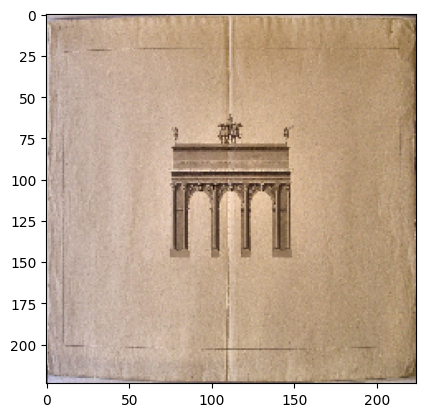

0 



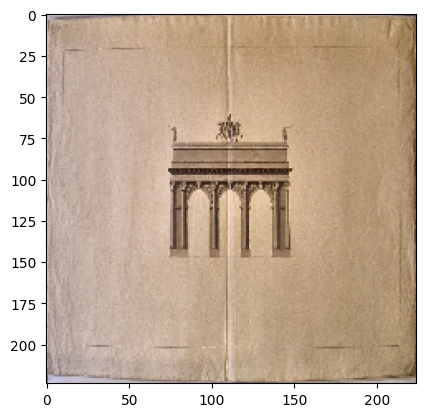

1 



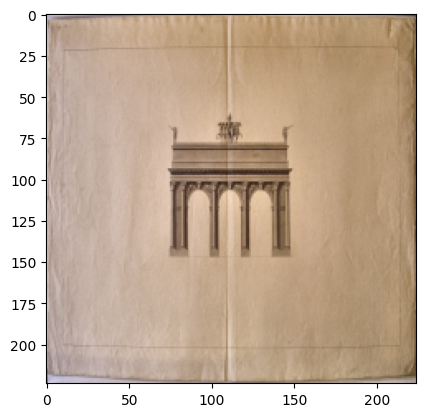

3 



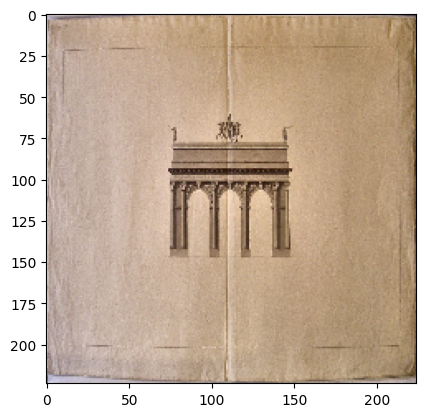

5 



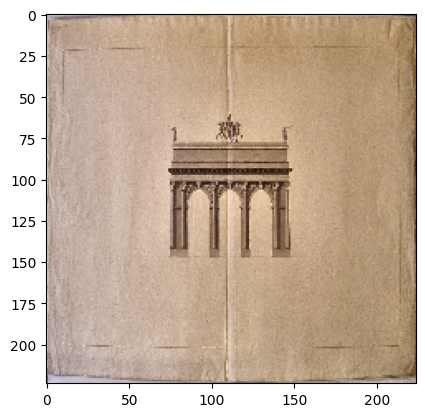

10 



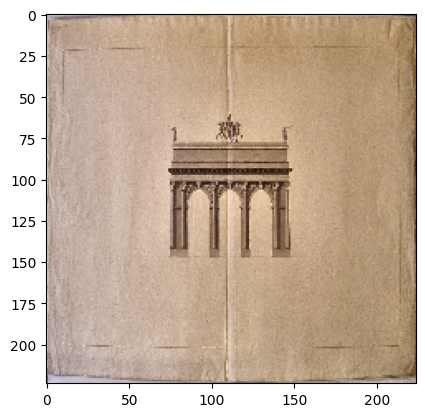

2 



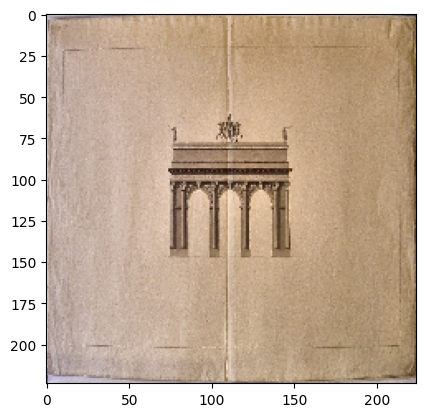

4 



In [ ]:

#AUGMENT Contrast
#https://stackoverflow.com/questions/39308030/how-do-i-increase-the-contrast-of-an-image-in-python-opencv
#https://en.wikipedia.org/wiki/Adaptive_histogram_equalization#:%7E:text=Contrast%20Limited%20AHE%20(CLAHE)%20is,slope%20of%20the%20transformation%20function.

tfIntType= [	cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_AREA, cv2.INTER_BITS, cv2.INTER_BITS2, cv2.INTER_CUBIC, cv2.INTER_LANCZOS4]

dim = (224, 224)

for intT in tfIntType:
  img = cv2.imread('/content/All/iccd102174893677r.jpg')
  # converting to LAB color space
  lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  l_channel, a, b = cv2.split(lab)

  # Applying CLAHE to L-channel
  # feel free to try different values for the limit and grid size:
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  cl = clahe.apply(l_channel)

  # merge the CLAHE enhanced L-channel with the a and b channel
  limg = cv2.merge((cl,a,b))
  # Converting image from LAB Color model to BGR color spcae
  img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

  #Interpolate
  img= cv2.resize(img, dim, interpolation= intT )
  img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img= np.asarray(img)
  plt.imshow(img/255)
  plt.show()
  print(intT,'\n')


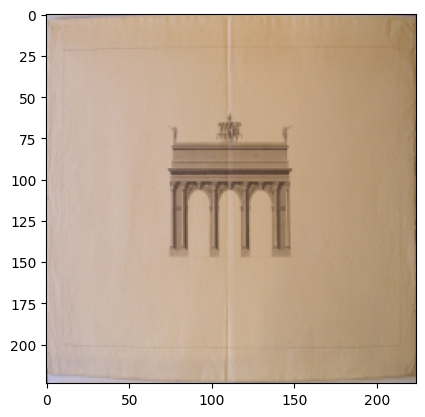

area 



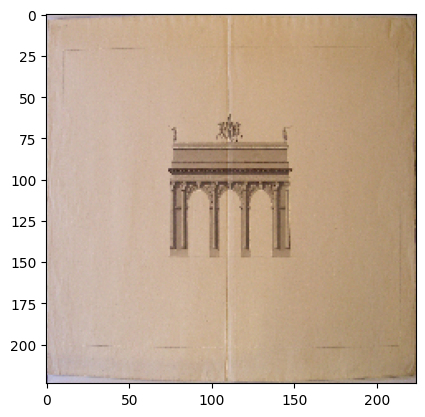

bicubic 



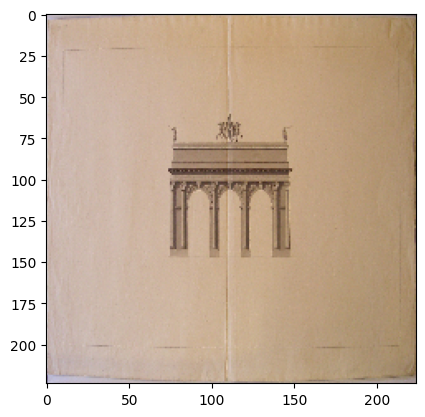

bilinear 



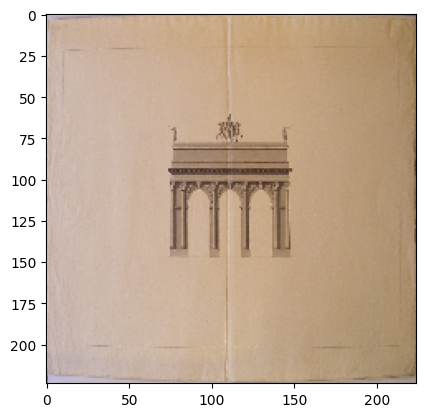

gaussian 



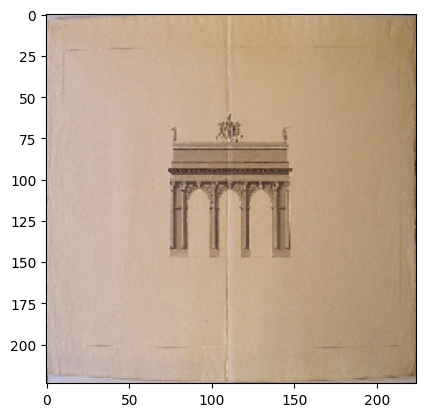

lanczos3 



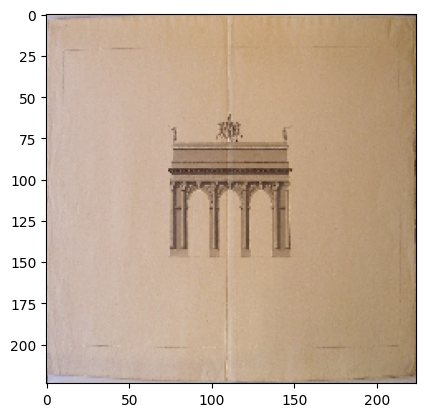

lanczos5 



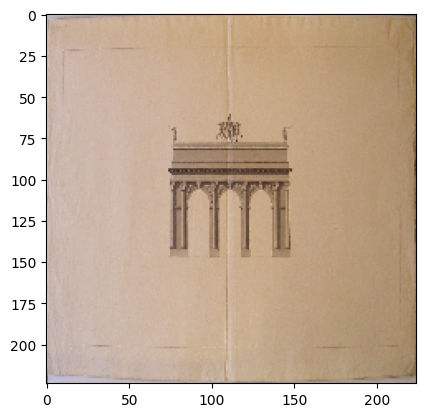

mitchellcubic 



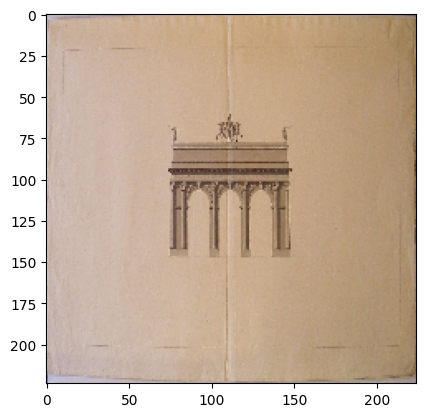

nearest 



In [ ]:
tfIntType= [	'area','bicubic','bilinear','gaussian','lanczos3','lanczos5','mitchellcubic','nearest']

for intT in tfIntType:
  img= tf.io.read_file('/content/All/iccd102174893677r.jpg')
  img= tf.io.decode_jpeg(img, channels=3, dct_method='INTEGER_ACCURATE')
  img= tf.image.resize(img, [224, 224], method=intT)
  img= img.numpy()
  plt.imshow(img/255)
  plt.show()
  print(intT,'\n')

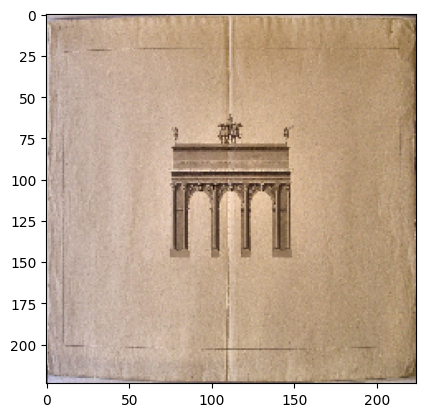

0 

0 



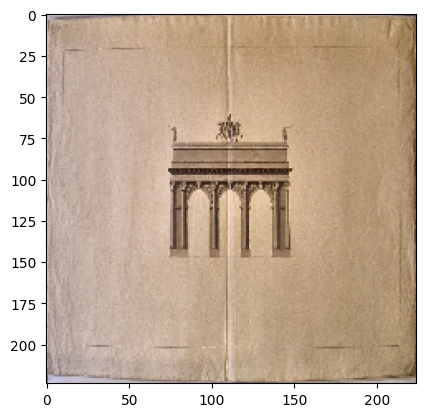

1 

1 



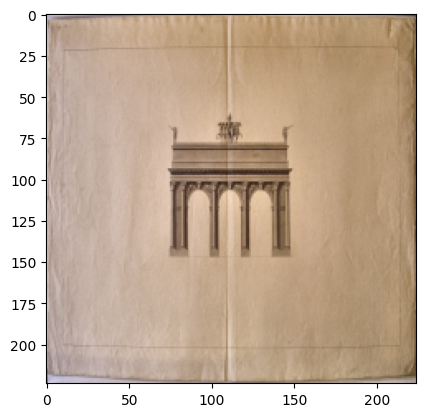

3 

3 



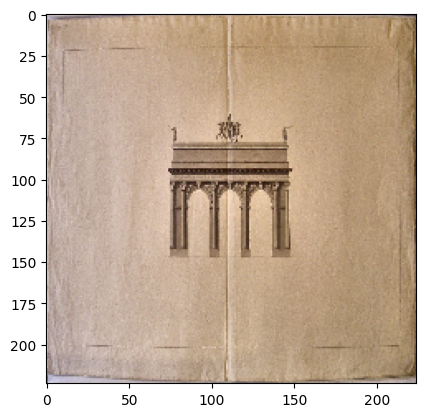

5 

5 



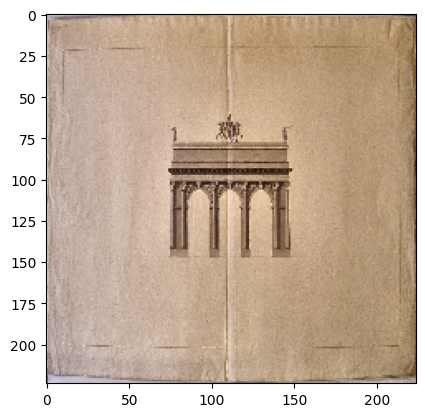

10 

10 



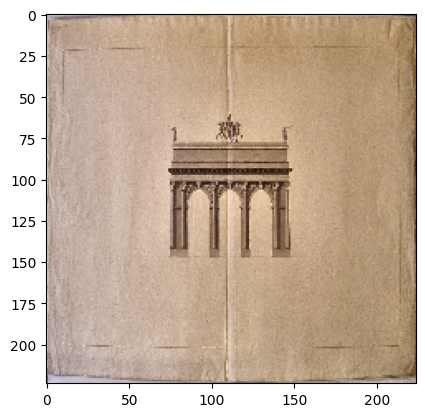

2 

2 



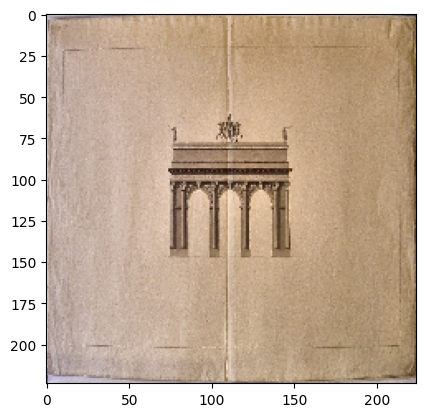

4 

4 



In [ ]:
tfIntType= [	cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_AREA, cv2.INTER_BITS, cv2.INTER_BITS2, cv2.INTER_CUBIC, cv2.INTER_LANCZOS4]

for intT in tfIntType:
  img= tf.io.read_file('/content/All/iccd102174893677r.jpg')
  img= tf.io.decode_jpeg(img, channels=3, dct_method='INTEGER_ACCURATE')
  img= tf.round(img).numpy()
  # converting to LAB color space
  lab=cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
  l_channel, a, b = cv2.split(lab)

  # Applying CLAHE to L-channel
  # feel free to try different values for the limit and grid size:
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  cl = clahe.apply(l_channel)

  # merge the CLAHE enhanced L-channel with the a and b channel
  limg = cv2.merge((cl,a,b))
  # Converting image from LAB Color model to BGR color spcae
  img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

  #Interpolate
  img= cv2.resize(img, dim, interpolation= intT )
  img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img= np.asarray(img)
  plt.imshow(img/255)
  plt.show()
  print(intT,'\n')
  print(intT,'\n')

## Def. Common functions

In [ ]:
#Files

def my_mkdir(folder, verbose=False):
  '''
  Create folder if dosn't exists
  '''
  try:
    #folder= os.path.join(os.getcwd(), folder)
    if verbose:
      print('Creating folder', folder, end='' )
    os.mkdir(folder)
    if verbose:
      print('...done.')
  except OSError as e:
    #pass
    if verbose:
      print('...NOT created!!! ',e)

def save_model(model, file_name='my_model.h5', verbose=True):
  '''
  Save model to file_name
  '''
  if verbose:
    print('Saving model',type(model).__name__,'to file',file_name, end='')
  res =pickle.dump(model, open(file_name, 'wb'))
  if verbose:
    print('...done.')
  return res

def load_model(file_name='my_model.h5', verbose=True):
  '''
  Load model from file_name
  Return model
  '''
  if verbose:
    print('Loading model from',file_name, end='')
  model =pickle.load(open(file_name, 'rb'))
  if verbose:
    print('...done.')
  return model

def check_img(f, verbose=False):
  '''
  Check if file exists and format is ok
  '''
  is_ok=True
  try:
    im = Image.open(f)
    im.verify()
    im.close()
    if verbose:
      print(f"OK: {f}")
  except (IOError, OSError, Image.DecompressionBombError):
    is_ok= False
    if verbose:
      print(f"Fail: {f}")

  if verbose :print('file check res:',is_ok)
  return is_ok

'''
#Use this for TENSORFLOW
def decode_img(img, norm=False, b_w=False, img_height=224, img_width=244):
  # Convert the compressed string to a 3D uint8 tensor

  img= tf.io.decode_jpeg(img, channels=3, dct_method='INTEGER_ACCURATE')
  if b_w:
    img= tf.image.rgb_to_grayscale(img)
  if norm:
    img=img/255
  # Resize the image to the desired size

  return tf.image.resize(img, [img_height, img_width], method='bilinear' )

def process_path(file_path, label, norm= False, b_w= False, img_height=224, img_width=224):
  # Load the raw data from the file as a string
  img = tf.io.read_file( file_path)
  img = decode_img(img, norm, b_w, img_height, img_width)
  return img, label
'''


def decode_img(img, norm=False, b_w=False, img_height=224, img_width=224, aug_contrast=False):
  #Use OpenCV

  if aug_contrast:
    #Augment the contrast of image
    # converting to LAB color space
    lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    # feel free to try different values for the limit and grid size:
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))
    # Converting image from LAB Color model to BGR color spcae
    img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

  #Interpolate
  img= cv2.resize(img, (img_width, img_height) , interpolation= cv2.INTER_AREA) # INTER_CUBIC )
  img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img= np.asarray(img)
  if norm:
    img=img/255
  # Resize the image to the desired size

  return img

def process_path(file_path, norm= False, b_w= False, img_height=224, img_width=224, aug_contrast=False):
  # Load the raw data from the file as a string
  try:
    img = cv2.imread(file_path)
    img = decode_img(img, norm, b_w, img_height, img_width, aug_contrast)
    return img
  except:
    return None


def load_from_json(file_and_path,
                   local_pic_folder= DATA_FOLDER,
                   split_perc=0.2,
                   norm= False,
                   b_w= False,
                   LABELS=LABELS,
                   FROM_NAME='choice',
                   DISCARD=[],            #List of label to discard,
                   DISCARD_DETAILS=False,
                   DETAILS_TO_OTHERS=False,
                   plot_f='',
                   verbose= False):
  '''
  Load images and labels from a Label Studio exported file.
  For each row, try first to load annotations, if not found load predictions.
  Images are shuffled.

  file_and_path: input path+file
  split_perc: parcentage for training and validation test, use 0 to return only training set
  norm: if true, then normalize (image */255)
  b_w: if True, transform in black and white
  verbose: if display logs
  DISCARD_DETAILS: if True discard details, if False look if DETAIL_TO OHETRS is true
  DETAILS_TO_OTHERS: if True convert image to Others (not used if DISCARD_DETAILS is True)
  SI
  Return:   train dataset,
            validation dataset (tensorflow data),
            list of training file name,
            list of val filename
  '''

  if norm:
    print('WARINING to be augmented values are expected to be in range 0-255, but you request to normalize !! (norm= True)')

  #Load infs from file
  data_file= open(file_and_path)
  jdata_list= json.load(data_file)
  data_file.close()
  print('JSON records', len(jdata_list))

  #Discard elements to one hot
  one_h_DISCARD=[1 if e in DISCARD else 0 for e in LABELS]

  #From json to lists
  file_list=[]
  y_list=[]
  for jdata in jdata_list:
    if verbose:
      print('json:', jdata)
    file_name= jdata.get('data').get('image')
    file_name= os.path.join(local_pic_folder, file_name.split('/')[-1])

    #Check if file exists, if don't go for next (don't append)
    is_ok= check_img(file_name)

    #Discard duplicates
    #Eliminata dopo la revisione del db
    #if ('_0'in file_name) or ('_1' in file_name):
    #  is_ok= False

    if not is_ok:
      if verbose: print(file_name,' not ok!\n')
      #next item without append
      continue

    try:
      results_val= jdata.get('annotations')[0].get('result')
      annot_val=''
      for res in results_val:
        if res.get('from_name')== FROM_NAME:
          #Prendo la label dell'immagine
          annot_val= res.get('value').get('choices')
        elif res.get('from_name')== 'user_tag':
          #Verifico user_tag: se e'un dettaglio, se e'in bubbio ecc
          usr_tag= res.get('value').get('choices')
          if 'Doubt' in usr_tag:
            #E'un bubbio quindi lo scarto
            if verbose:
              print(jdata.get('id'),'is doubt.')
            is_ok= False
          if 'Detail' in usr_tag:
            #E'un dettaglio
            if verbose:
              print(jdata.get('id'),'detail detected')
            if DISCARD_DETAILS:
              #Lo scarto
              if verbose:
                print('Detail discarted')
              is_ok= False
            elif DETAILS_TO_OTHERS:
              #Lo converto in Others
              if verbose:
                print('Detail to Others')
              annot_val=['Others']

      if not is_ok:
        #Is a Detail and has to be discarted
        if verbose: print('\n')
        #next item without append
        continue

      if len(annot_val)==0:
        raise ValueError
      #annot_val= jdata.get('annotations')[0].get('result')[0].get('value').get('choices')
    except (IndexError, ValueError) as e:
      if verbose: print('annotations not found, try with predictions')
      try:
        annot_val= jdata.get('predictions')[0].get('result')[0].get('value').get('choices')
      except:
        if verbose: print('also prediction not found, assigning manual label (Others)')
        annot_val= LABELS[-1]


    #To one hot
    one_h_annot_val= [1 if ele in annot_val else 0 for ele in LABELS]

    #Filter Error labelling Others+others label at 1
    if (one_h_annot_val[-1]==1) and (sum(one_h_annot_val)>1):
      one_h_annot_val[-1]=0

    #Chack if labels are in DISCARD, if so discard it
    #Example annot=[0,1,0,1]
    #        disc =[0,0,0,1]
    #        mult  [0,0,0,1]
    #        sum    1 so is to discard
    if sum([a*b for a,b in zip(one_h_annot_val,one_h_DISCARD)])>0:
      if verbose:
        print('Label', annot_val,'in', DISCARD,': DISCARTED.\n')
      continue  #discard

    #Good input....add it
    file_list.append(file_name)
    y_list.append(one_h_annot_val)

    if verbose:
      print('File&Path:', file_name, '\nAnnot.:',annot_val, '\nOneHot:',one_h_annot_val,'\n')

  image_count= len(y_list)
  print('Found',image_count,'files')

  #Plot
  #Count and ploat each class
  print('\nSingle class count')
  count = count_each_class(np.array(y_list))
  plot_pet_from_dict(count,plt_file='02_Data'+plot_f+'_single_class_count.png')                   #plot single class
  print('\n')

  #Count and plot multiple class
  print('\nMultiple class count')
  cnt, unq= count_uniq_rows(np.array(y_list) )
  lab_lst=[]
  for u in unq:
    #print(u)
    lab_lst.append(str([b for a, b in zip(u, LABELS) if a]))
  # Plotting
  plt.bar(lab_lst,cnt,  color='red')
  plt.tick_params(axis='x', rotation=90)
  #plt.figure(figsize=(8.0,6.0))
  plt.savefig(os.path.join(PLOT_FOLDER, '01_Data'+plot_f+'_Multi_class_count.png'))
  plt.show()
  print('\n')
  #-End plot---

  #Build dataset
  img_list_ds= pd.DataFrame()
  img_list_ds['X'] = file_list
  img_list_ds['y'] = y_list

  if verbose:
    print(img_list_ds.head(5))
  #Shuffle
  img_list_ds = img_list_ds.sample(frac=1, random_state=3).reset_index(drop=True)  #<<<<<  Shuffle with seed to replicate
  if verbose:
    print(img_list_ds.head(5))

  #Create validation set
  val_size = int(image_count * split_perc)
  train_img_file_ds = img_list_ds[val_size: ]
  val_img_file_ds = img_list_ds[ :val_size]

  train_img_file_list=train_img_file_ds['X']
  print('\nTot n. of example for training', len(train_img_file_list))
  val_img_file_list=val_img_file_ds['X']
  print('Tot n. of example for test', len(val_img_file_list))

  #Load images
  train_ds= pd.DataFrame()
  train_ds['X'] = train_img_file_ds.apply(lambda row : process_path(row['X'],
                                                             norm,
                                                             b_w,
                                                             IMG_HEIGHT,
                                                             IMG_WIDTH,
                                                             aug_contrast=False),
                                     axis=1
                                  )
  train_ds['y']= train_img_file_ds['y']

  val_ds = pd.DataFrame()
  val_ds['X']   = val_img_file_ds.apply(lambda row : process_path(row['X'],
                                                           norm,
                                                           b_w,
                                                           IMG_HEIGHT,
                                                           IMG_WIDTH,
                                                           aug_contrast=False),
                                   axis=1
                                )
  val_ds['y']= val_img_file_ds['y']

  #Take only filename
  train_img_file_list= train_img_file_list.tolist()
  val_img_file_list= val_img_file_list.tolist()

  return train_ds, val_ds, train_img_file_list, val_img_file_list

def configure_for_performance(ds, batch_size=8, at=AUTOTUNE):
  ds = ds.cache()
  #ds = ds.shuffle( buffer_size=5000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=at)
  return ds


In [ ]:
#Metrics
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
#Count and plot
def count_each_class(app_arr, labels=LABELS):
  '''
  Input: array of labels es:  array([[0, 0, 1, 0],
                                     [0, 1, 1, 0],
                                     [0, 0, 0, 0]], dtype=int32)
  count how many examples became from each class (label)
  '''
  res={}
  for i in range(len(LABELS)):
    res[LABELS[i]]= app_arr[:,i].sum()
  return res

def plot_pet_from_dict(your_data, plt_file='02_Data_single_class_count.png'):
  '''
  Pie data to plot.
  Input: dictionary
  '''

  labels = []
  sizes = []

  for x, y in your_data.items():
      labels.append(x)
      sizes.append(y)

  # Plot
  plt.pie(sizes,
                  pctdistance = 1.2,
        labeldistance = 1.4,
        autopct=lambda x: f'({(x/100)*sum(sizes):.0f})\n{x:.1f}%',
          labels=labels)

  plt.axis('equal')
  plt.savefig(os.path.join(PLOT_FOLDER, plt_file))
  plt.show()


def binatodeci(binary):
  '''
  Binary number to decimal
  '''
  return sum(val*(2**idx) for idx, val in enumerate(reversed(binary)))

def multilabel_stat(y,pred,labels=LABELS, display_plot= True, plt_file='03_Multi_conf_matrics.png'):
  '''
  Plot confusio metrics and print statistics
  y: true (real output)
  pred: predicted output
  labels: class labels
  '''
  #PLOT GRAPH
  if display_plot:
    print('Multi-class confusion matrix')
    cm_list = multilabel_confusion_matrix(y, pred).tolist()

    f, axes = plt.subplots(1, 4, figsize=(20, 5))#, sharey='row')

    for i, cm, label in zip(range(len(labels)), cm_list, labels):
      disp = ConfusionMatrixDisplay(confusion_matrix=np.array(cm), display_labels=['All Others', label])

      disp.plot(ax=axes[i], xticks_rotation=45 )
      disp.ax_.set_title('Conf. mat. for class '+label)
      disp.im_.colorbar.remove()
      disp.ax_.set_xlabel('')
      if i!=0:
          disp.ax_.set_ylabel('')

    f.text(0.4, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.40, hspace=0.1)
    f.colorbar(disp.im_, ax=axes)
    plt.savefig(os.path.join(PLOT_FOLDER, plt_file))
    plt.show()

  #DISPLAY DATA
  print('Multiclass report')
  lab_lst=[]
  uniq= np.unique(y, axis=0)
  lab= [str(np.array(LABELS)[v.astype(bool)].tolist()) for v in uniq]

  cl=classification_report(np.array([binatodeci(row) for row in y]),
                          np.array([binatodeci(row) for row in pred]),
                          labels= np.array([binatodeci(row) for row in uniq]),
                          target_names= lab,
                          zero_division=0,
                          output_dict= False)

  '''
  with pd.option_context('display.float_format', '{:0.3f}'.format):
    print(pd.DataFrame.from_dict(dict((k, v) for k, v in cl.items() if v['support'] > 0)).T)
  '''
  print(cl)

def count_uniq_rows(my_array):
  '''
  Count same rows in numpy array

  Return count array , unique lists of arrays
  '''
  dt = np.dtype((np.void, my_array.dtype.itemsize * my_array.shape[1]))
  b = np.ascontiguousarray(my_array).view(dt)
  unq, cnt = np.unique(b, return_counts=True)
  unq = unq.view(my_array.dtype).reshape(-1, my_array.shape[1])

  return cnt, unq


In [ ]:
transf_list=[
    iaa.Fliplr(1),
    iaa.Flipud(1),
    iaa.Affine(rotate=(-45, 45)),
    iaa.Affine(rotate=(-90, 90)),
    iaa.Affine(scale=(0.5, 2.0)),
    iaa.GaussianBlur(sigma=(0.0, 3.0)),
    iaa.BlendAlpha((0.0, 1.0),foreground=iaa.Add(100),background=iaa.Multiply(0.2)),
    #iaa.LogContrast(gain=(0.6, 0.8)),
    #iaa.AdditiveGaussianNoise(scale=(0, 0.2*255)),
    #iaa.AdditiveLaplaceNoise(scale=(0, 0.2*255)),
    #iaa.MultiplyElementwise((0.5, 1.5)),
    iaa.Cutout(nb_iterations=(1, 5), size=0.1, squared=False, cval=0),
    iaa.Cutout(fill_mode="constant", cval=255),
    iaa.Dropout(p=(0, 0.1)),
    iaa.CoarseDropout((0.0, 0.05), size_percent=(0.02, 0.15)),
    iaa.ReplaceElementwise(0.08, [0, 255]),
    iaa.Salt(0.08),
    iaa.Pepper(0.08),
    ]

# seq =iaa.Sometimes(5 / 6, iaa.OneOf(transf_list)
# seq = iaa.OneOf(transf_list)

seq = iaa.SomeOf((1, 4),transf_list)

In [ ]:
class Aug_Sequence(Sequence):
    '''
    Augment while trining.<br>
    Apply augmentation to the x_set, y_set of batch
    '''
    def __init__(self, x_set, y_set, batch_size, augmentations):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return  self.augment(images= batch_x), np.array(batch_y)

In [ ]:
# get the model
def get_model(n_inputs, n_outputs):
  model = Sequential()
  model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dense(n_outputs, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy',f1_m])
  return model

 # evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
  results = list()
  n_inputs, n_outputs = X.shape[1], y.shape[1]
  # define evaluation procedure
  cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
  # enumerate folds
  for train_ix, test_ix in cv.split(X):
    # prepare data
    X_train, X_test = X[train_ix,:], X[test_ix,:]
    y_train, y_test = y[train_ix,:], y[test_ix,:]
  # define model
  model = get_model(n_inputs, n_outputs)
  # fit model
  model.fit(X_train, y_train, verbose=0, epochs=100)
  # make a prediction on the test set
  yhat = model.predict(X_test)
  # round probabilities to class labels
  yhat = yhat.round()
  # calculate accuracy
  acc = accuracy_score(y_test, yhat)
  # store result
  print('>%.3f' % acc)
  results.append(acc)
  return results

In [ ]:
#Augmentation

def compose_img(id0=0,id1=1,x=None,y=None,verbose=False):
  '''
  Take two images, randomly rotate, and merge as one
  id0: first index,
  id1: second index,
  x: numpy array of images
  y: numpy array of labels (optional, use only if verbose)

  '''
  img0= x_train[id0]
  img1= x_train[id1]

  if verbose:
    print(str(id0),' label:', y_train[id0])
    print(str(id1),' label:', y_train[id1])
    print('Original images')
    plt.imshow(img0, interpolation='nearest')
    plt.show()
    plt.imshow(img1, interpolation='nearest')
    plt.show()

  #Rotate first img
  kr= random.randint(0,3)
  img0r= np.rot90(img0,k=kr, axes=(0,1))

  if verbose:
    print(str(id0),'Rotation')
    plt.imshow(img0r, interpolation='nearest')
    plt.show()

  #Rotate second img
  kr= random.randint(0,3)
  img1r= np.rot90(img1,k=kr, axes=(0,1))

  if verbose:
    print(str(id1),'Rotation')
    plt.imshow(img1r, interpolation='nearest')
    plt.show()

  #put images one next others
  h1, w1 = img0r.shape[:2]
  h2, w2 = img1r.shape[:2]

  #create empty matrix
  vis = np.zeros((max(h1, h2), w1+w2,3), np.uint8)

  #combine 2 images
  vis[:h1, :w1,:3] = img0r
  vis[:h2, w1:w1+w2,:3] = img1r
  kr= random.randint(0,3)
  vis= np.rot90(vis,k=kr, axes=(0,1))

  if verbose:
    print('Composed and rotated')
    plt.imshow(vis, interpolation='nearest')
    plt.show()

  #Resize
  vis = cv2.cvtColor(vis, cv2.COLOR_RGB2BGR)
  vis= cv2.resize(vis, (w1, h1) , interpolation= cv2.INTER_CUBIC )
  vis = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)

  if verbose:
    print('Resized')
    plt.imshow(vis, interpolation='nearest')
    plt.show()
  return vis

def bool2int(x):
  '''Binary to Int'''
  x=reversed(x)
  y = 0
  for i,j in enumerate(x):
      y += j<<i
  return y

def int2bool(x):
  '''Int to Binary'''
  return [int(i) for i in bin(x)[2:].zfill(4)]
'''
#Only to test
id0=10
id1=1220
_ =compose_img(id0= 0,
               id1= 1,
               x= x_train,
               y= y_train,
               verbose= False)
'''
def gen_2_images(n, blabel0, blabel1, x, y, verbose=False):
  '''
  Generate n new images from a couple of labels
  return: np array of new images, np array of lavels (mix of the two in input)
  '''

  if True:
    print('Generating new images')
    print('label0', str(np.array(LABELS)[np.array(blabel0).astype(bool)].tolist()), str(bool2int(blabel0)))
    print('label1', str(np.array(LABELS)[np.array(blabel1).astype(bool)].tolist()), str(bool2int(blabel1)))
    print('n=',n)

  label0= bool2int(blabel0)
  label1= bool2int(blabel1)

  if True:
    print('Output:', str(np.array(LABELS)[(np.array(blabel0)+np.array(blabel1)).astype(bool)].tolist()))

  y= np.array([bool2int(x) for x in y])

  #Get index of label0
  idxs0= np.where(y== label0)[0]
  #Get n random indexes
  r= random.sample(range(0, len(idxs0)), n)
  #Get the indexes
  idxs0=idxs0[r]
  if verbose:
   print('Label 0 indexes',idxs0)

  #Get index of label1
  idxs1= np.where(y== label1)[0]
  #Get n random indexes
  r= random.sample(range(0, len(idxs1)), n)
  #Get the indexes
  idxs1=idxs1[r]
  if verbose:
   print('Label 1 indexes',idxs1)

  img_list=[]
  for id0,id1 in zip(idxs0,idxs1):
    img =compose_img(id0,
                    id1,
                    x,
                    y,
                    verbose)
    img_list.append(img)

  lab_list = [(np.array(blabel0)+np.array(blabel1)).tolist()] * n
  return np.stack(img_list), np.stack(lab_list)


def my_balance(x_train, y_train, sampling_strategy='auto'):
    '''
    Applica RandomOversalpling al dataset
    '''
    print('Shape before aug of train set : input', x_train.shape, '; output', y_train.shape)

    # y to integer
    y_train = [bool2int(x) for x in y_train]
    y_train = np.array(y_train)

    # Reshape X
    img_r = x_train.shape[1]
    img_c = x_train.shape[2]
    img_l = x_train.shape[3]

    # Augment
    x_train = x_train.reshape((x_train.shape[0], img_r * img_c * img_l))

    ros = RandomOverSampler(random_state=0, sampling_strategy=sampling_strategy)

    x_train, y_train = ros.fit_resample(x_train, y_train)
    # Reshape back X
    x_train = x_train.reshape((x_train.shape[0], img_r, img_c, img_l))
    # y to boolean
    y_train = np.array([int2bool(x) for x in y_train])
    print('Shape after aug of train set : input', x_train.shape, '; output', y_train.shape)

    return x_train, y_train

In [ ]:
def opt_PRC_thresholds(y_true,y_pred,labels=LABELS):
  '''
  Optimal Threshold for Precision-Recall Curve
  ytrue: real output
  yhat: model output
  labels (default LABELS)
  return list of dictionary [{'label': 'Plan', 'thr': 0.48511228, 'f1-score': 0.8680351906158358}, {'label': 'Elevation', 'thr': 0.40432772, 'f1-score': 0.872628726287263}, {'label': 'Section', 'thr': 0.53344375, 'f1-score': 0.8376623376623378}, {'label': 'Others', 'thr': 0.50058603, 'f1-score': 0.9277777777777778}]
  '''
  print('Optimal Threshold for Precision-Recall Curve')
  res=[]
  for lab in range(len(labels)):
    #Multi class to binary
    yhat=y_pred[:,lab]
    ytrue=y_true[:,lab]
    # calculate roc curves
    precision, recall, thresholds = precision_recall_curve(ytrue, yhat)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    res.append(({'label':LABELS[lab],
                'thr':thresholds[ix],
                'f1-score':fscore[ix]}))
    print(LABELS[lab],'- Best Threshold=%.3f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
    # plot the roc curve for the model
    no_skill = len(ytrue[ytrue==1]) / len(ytrue)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label='Model')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    #Save
    plt.savefig(os.path.join(PLOT_FOLDER, '08_Threshold_f1'+LABELS[lab]+'.png'))
    # show the plot
    plt.show()

  print ('Threshols for f1 optimization:\n',res)
  return res

def opt_ROC_thresholds(y_true,y_pred,labels=LABELS):
  '''
  Optimal Threshold for ROC Curve
  ytrue: real output
  yhat: model output
  labels (default LABELS)
  return list of dictionary [{'label': 'Plan', 'thr': 0.48511228, 'f1-score': 0.8680351906158358}, {'label': 'Elevation', 'thr': 0.40432772, 'f1-score': 0.872628726287263}, {'label': 'Section', 'thr': 0.53344375, 'f1-score': 0.8376623376623378}, {'label': 'Others', 'thr': 0.50058603, 'f1-score': 0.9277777777777778}]
  '''
  print('Optimal Threshold for ROC Curve')
  res=[]
  for lab in range(len(labels)):
    #Multi class to binary
    yhat=y_pred[:,lab]
    ytrue=y_true[:,lab]
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(ytrue, yhat)
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    res.append(({'label':LABELS[lab],
                'thr':thresholds[ix],
                'g-mean':gmeans[ix]}))
    print(LABELS[lab],'- Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='Model')
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    #Save
    plt.savefig(os.path.join(PLOT_FOLDER, '07_Threshol_g_gmean'+LABELS[lab]+'.png'))
    # show the plot
    plt.show()

  print ('Threshols for g-mean optimization:\n',res)
  return res




In [ ]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
 return (pos_probs >= threshold).astype('int')

def opt_f1_thresholds(y_true,y_pred,labels=LABELS):
  '''
  Optimal Threshold for ROC Curve
  ytrue: real output
  yhat: model output
  labels (default LABELS)
  return list of dictionary [{'label': 'Plan', 'thr': 0.48511228, 'f1-score': 0.8680351906158358}, {'label': 'Elevation', 'thr': 0.40432772, 'f1-score': 0.872628726287263}, {'label': 'Section', 'thr': 0.53344375, 'f1-score': 0.8376623376623378}, {'label': 'Others', 'thr': 0.50058603, 'f1-score': 0.9277777777777778}]
  '''
  print('Optimal Threshold for f1 Score')
  res=[]
  for lab in range(len(labels)):
    #Multi class to binary
    yhat=y_pred[:,lab]
    ytrue=y_true[:,lab]

    # define thresholds
    thresholds = np.arange(0, 1, 0.001)
    # evaluate each threshold
    scores = [metrics.f1_score(ytrue, to_labels(yhat, t)) for t in thresholds]
    # locate the index of the largest g-mean
    ix = np.argmax(scores)
    res.append(({'label':LABELS[lab],
                'thr':thresholds[ix],
                'f1':scores[ix]}))
    print(LABELS[lab],'Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))


  print ('Threshols for f-1 optimization:\n',res)
  return res

In [ ]:
def predict_thresholds(model, x_test, thresholds):
  '''
  Predict applying thresholds.
  If [0,0,0,0] is predicted than the class is the most significative also if it doesn't pass threshold.

  model,
  x_test,
  thresholds

  Return Predicted output (Array of boolean lists), Sure level (boolena: 1 sure, 0 not sure).
  For sure level: prediction are not sure il non of val is grather than thresold => [0,0,0,0] but
  the argmax is taken.
  '''
  print('Using optimized thresholds')
  y_pred= model.predict(x_test)

  level= np.ones(y_pred.shape[0])   #livello di sicurezza della predizione

  #Filter by thresholds to binary output
  thr_arr=np.array([t['thr'] for t in thresholds])
  thr_arr=np.tile(thr_arr, (y_pred.shape[0],1))
  res= y_pred> thr_arr
  res = res.astype('int32')
  #Set sure level (if [0,0,0,0] than not a sure prediction)
  level[np.sum(res, axis=1)==0]= 0
  #if all output are all zeros than take the one with highter probab.
  res[np.sum(res, axis=1)==0, np.argmax(y_pred[np.sum(res, axis=1)==0], axis=1)]=1

  return res, level

In [ ]:
def plot_pred_distr(y_pred, y_true, labels=LABELS, n_beans= 20, title='Title', thresholds=[{'label': 'Plan',
                                                                                            'thr': 0.5},
                                                                                            {'label': 'Elevation',
                                                                                            'thr': 0.5},
                                                                                            {'label': 'Section',
                                                                                            'thr': 0.5},
                                                                                            {'label': 'Others',
                                                                                            'thr': 0.5}]):
  #Plot distributions for one vs others
  #of values predicted for one and zero true value
  for ind, l in enumerate(labels):
    yt=y_true[:,ind]
    yp=y_pred[:,ind]
    vals_one=  yp[yt==1]
    vals_zero= yp[yt==0]

    vals_one.shape,vals_zero.shape
    bins = np.linspace(0,1, n_beans)

    plt.hist(vals_one,  bins, alpha=0.5, label='One vals')
    plt.hist(vals_zero, bins, alpha=0.5, label='Zero vals')
    plt.legend(loc='upper right')
    plt.title(str(title+l))
    plt.annotate('Threshold',
                  xy=(thresholds[ind]['thr'], 0),
                  xytext=(thresholds[ind]['thr'], -0.3),
                  arrowprops = dict(facecolor='black', shrink=0.05))
    plt.show()

#Load data (train/val/test)

JSON records 4068
Found 3489 files

Single class count


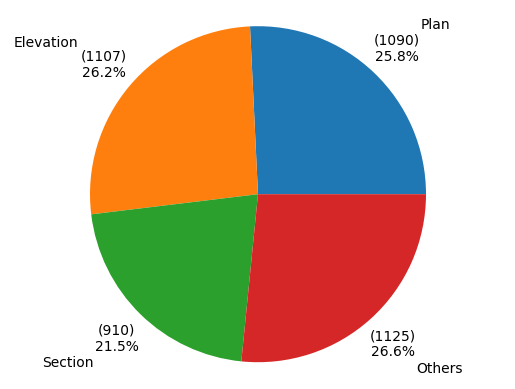




Multiple class count


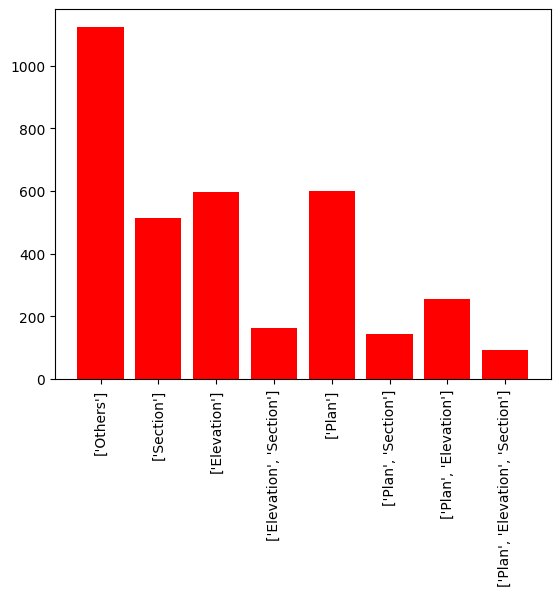




Tot n. of example for training 2443
Tot n. of example for test 1046


In [ ]:
#Load Data from JSON and split Training and Test set
train_ds, test_ds, train_img_file_list, test_img_file_list= load_from_json(os.path.join( DATA_FOLDER, LS_FILE),
                                                                           split_perc= SPLIT_TRAIN_TEST,
                                                                           norm= NORM_IMAGE,
                                                                           b_w= BW_IMAGE,
                                                                           FROM_NAME='choice',
                                                                           #DISCARD=[LABELS[-1]],   #Discard 'Others'
                                                                           DISCARD_DETAILS=DISCARD_DETAILS,
                                                                           DETAILS_TO_OTHERS= DETAILS_TO_OTHERS,
                                                                           verbose= False)

In [ ]:
x_train, y_train = np.stack(train_ds['X'].to_list()), np.stack(train_ds['y'].to_list())
x_test, y_test = np.stack(test_ds['X'].to_list()), np.stack(test_ds['y'].to_list())

In [ ]:
del train_ds
gc.collect()

3628

In [ ]:
#Split training and validation here to augment only trainin not validation
cl= [''.join(str(lab)  for lab in y) for y in y_train]
x_train, x_val, y_train, y_val, train_img_file_list, val_img_file_list = train_test_split(x_train, y_train,
                                                                                          train_img_file_list,
                                                                                          test_size=SPLIT_TRAIN_VAL,
                                                                                          stratify=cl,
                                                                                          random_state=42)

Training set - Multiple class count, tot 1954


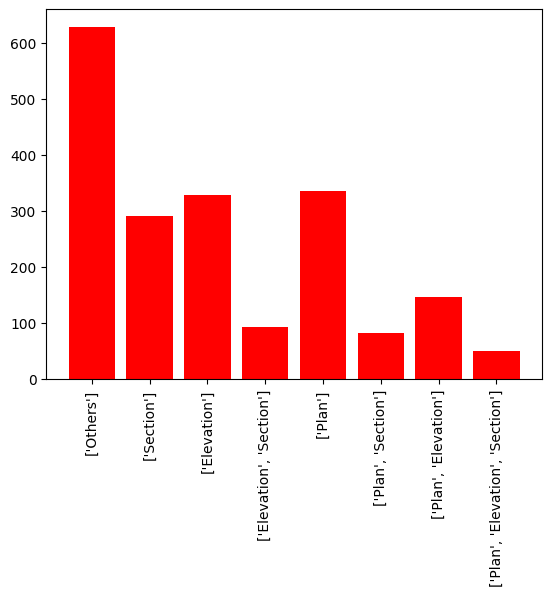

In [ ]:
#Count and plot multiple class
print('Training set - Multiple class count, tot',str(y_train.shape[0]))
cnt, unq= count_uniq_rows(y_train )
lab_lst=[]
for u in unq:
  #print(u)
  lab_lst.append(str([b for a, b in zip(u, LABELS) if a]))
# Plotting
plt.bar(lab_lst,cnt,  color='red')
plt.tick_params(axis='x', rotation=90)
plt.savefig(os.path.join(PLOT_FOLDER, '03_Training_set_class_count.png'))
plt.show()
#-End plot---

In [ ]:
print('Shape control:')
print('Train - input:',x_train.shape,', out:',y_train.shape,', files',len(train_img_file_list))
print('Valid - input:',x_val.shape,', out:',y_val.shape,', files',len(val_img_file_list))
print('Test  - input:',x_test.shape,', out:',y_test.shape,', files',len(test_img_file_list))

Shape control:
Train - input: (1954, 224, 224, 3) , out: (1954, 4) , files 1954
Valid - input: (489, 224, 224, 3) , out: (489, 4) , files 489
Test  - input: (1046, 224, 224, 3) , out: (1046, 4) , files 1046


### Join Picryl

JSON records 3107
Found 2924 files

Single class count


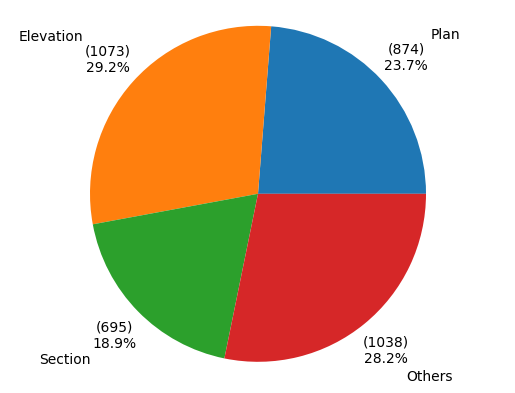




Multiple class count


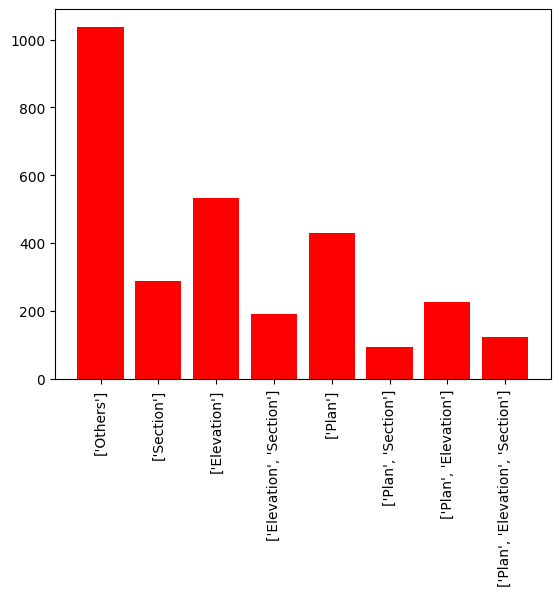




Tot n. of example for training 2922
Tot n. of example for test 2


In [ ]:
#Load Data from PICRYL
train_ds_pic, _, train_img_file_list_pic, _= load_from_json(os.path.join( DATA_FOLDER_PICRYL, LS_FILE_PICRYL),
                                                            local_pic_folder= DATA_FOLDER_PICRYL,
                                                            split_perc= 0.001,
                                                            norm= NORM_IMAGE,
                                                            b_w= BW_IMAGE,
                                                            FROM_NAME='choice',
                                                            #DISCARD=[LABELS[-1]],   #Discard 'Others'
                                                            plot_f='_pic',
                                                            DISCARD_DETAILS= DISCARD_DETAILS,
                                                            DETAILS_TO_OTHERS= DETAILS_TO_OTHERS,
                                                            verbose= False)

In [ ]:
x_train_pic, y_train_pic = np.stack(train_ds_pic['X'].to_list()), np.stack(train_ds_pic['y'].to_list())

In [ ]:
del train_ds_pic
gc.collect()

3689

In [ ]:
#JOIN data
x_train = np.vstack((x_train, x_train_pic))
y_train = np.vstack((y_train, y_train_pic))
train_img_file_list =train_img_file_list+train_img_file_list_pic

In [ ]:
print('Shape control:')
print('Train - input:',x_train.shape,', out:',y_train.shape,', files',len(train_img_file_list))
print('Valid - input:',x_val.shape,', out:',y_val.shape,', files',len(val_img_file_list))
print('Test  - input:',x_test.shape,', out:',y_test.shape,', files',len(test_img_file_list))

Shape control:
Train - input: (4876, 224, 224, 3) , out: (4876, 4) , files 4876
Valid - input: (489, 224, 224, 3) , out: (489, 4) , files 489
Test  - input: (1046, 224, 224, 3) , out: (1046, 4) , files 1046


In [ ]:
#Save original dataset
x_train_orig=x_train.copy()
y_train_orig=y_train.copy()
train_img_file_list_orig=train_img_file_list.copy()

### Compose new images
Since dataset is unbalanced mainly because mixed images are not enough, this routine try to compose new mixed images starting from the others.


In [ ]:
print('Train images x',x_train.shape[0],', train images y',y_train.shape[0])
print('Composing new images...')

Train images x 4876 , train images y 4876
Composing new images...


In [ ]:
aug_list=[{
              'label0': [1,0,0,0],
              'label1': [0,1,0,0],
              'n':0
          },
          {
              'label0': [1,0,0,0],
              'label1': [0,0,1,0],
              'n':0
          },
          {
              'label0': [0,1,0,0],
              'label1': [0,0,1,0],
              'n':0
          },
          {
              'label0': [1,1,0,0],
              'label1': [0,0,1,0],
              'n':0
          }]

In [ ]:
print(LABELS,'\n')

for aug in aug_list:
  label0= aug['label0']
  label1= aug['label1']
  n= aug['n']

  if n>0:
    new_x , new_y = gen_2_images(n, label0, label1, x_train, y_train, verbose=False)
    x_train= np.concatenate((x_train, new_x))
    y_train= np.concatenate((y_train, new_y))
    print('\n')

['Plan', 'Elevation', 'Section', 'Others'] 



In [ ]:
print('Train images x',x_train.shape[0],', train images y',y_train.shape[0])

Train images x 4876 , train images y 4876


### Balance Dataset

In [ ]:
if TRAIN_ON_ALL_DATA:
  #JOIN dataset
  x_train = np.vstack((x_train, x_val, x_test))
  y_train = np.vstack((y_train, y_val, y_test))
  train_img_file_list =train_img_file_list+val_img_file_list+test_img_file_list
  print('Train on ALL data...')
  #Augmentation by class
  s_st={
        2:  1350,   #Section
        4:  1350,   #Elevation
        6:   850,   #Elevation+Section
        8:  1350,   #Plan
        10:  850,   #Plan+Section
        12:  850,   #Plan+Elevation
        14:  850    #Plan+Elevation+Section
  }

elif TRAIN_ON_TRAIN_AND_VAL:
  #JOIN dataset
  x_train = np.vstack((x_train, x_val))
  y_train = np.vstack((y_train, y_val))
  train_img_file_list =train_img_file_list+val_img_file_list
  print('Train on Training + Validation data...')
  #Augmentation by class
  s_st={
        2:  1300,   #Section
        4:  1300,   #Elevation
        6:   800,   #Elevation+Section
        8:  1300,   #Plan
        10:  800,   #Plan+Section
        12:  800,   #Plan+Elevation
        14:  800    #Plan+Elevation+Section
  }

else:
  #Don't join
  print('Train on Training data only...')
  #Augmentation by class
  s_st={
        2:  1250,   #Section
        4:  1250,   #Elevation
        6:   750,   #Elevation+Section
        8:  1250,   #Plan
        10:  750,   #Plan+Section
        12:  750,   #Plan+Elevation
        14:  750    #Plan+Elevation+Section
  }


Train on Training data only...



Balance Dataset
Multiple class count, tot 4876


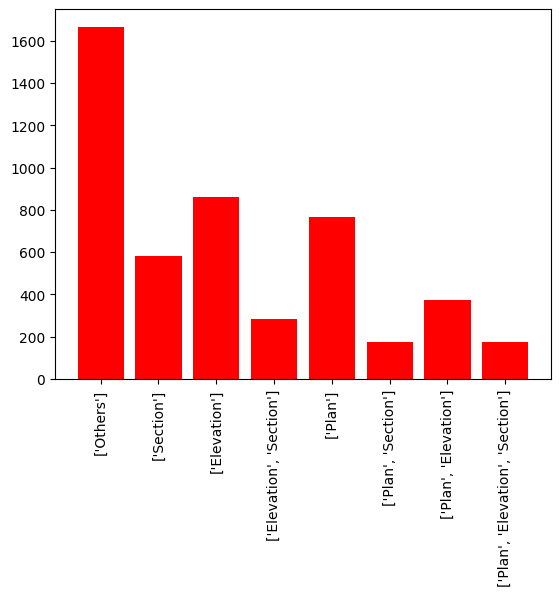

In [ ]:
print('\nBalance Dataset')
#Count and plot multiple class
print('Multiple class count, tot',str(y_train.shape[0]))
cnt, unq= count_uniq_rows(y_train )
lab_lst=[]
for u in unq:
  #print(u)
  lab_lst.append(str([b for a, b in zip(u, LABELS) if a]))

# Plotting
plt.bar(lab_lst,cnt,  color='red')
plt.tick_params(axis='x', rotation=90)
plt.savefig(os.path.join(PLOT_FOLDER, '04_Before_balance_class_count.png'), dpi=300, bbox_inches='tight')
plt.show()
#-End plot---

In [ ]:
print('Labels',LABELS)

Labels ['Plan', 'Elevation', 'Section', 'Others']


In [ ]:
#Balance training set (and validation set)
#Comment to augment only training and do it after split

x_train, y_train = my_balance(x_train, y_train, sampling_strategy= s_st)

print('Train images x',x_train.shape[0],', train images y',y_train.shape[0])


Shape before aug of train set : input (4876, 224, 224, 3) ; output (4876, 4)
Shape after aug of train set : input (8417, 224, 224, 3) ; output (8417, 4)
Train images x 8417 , train images y 8417


Multiple class count, tot 8417


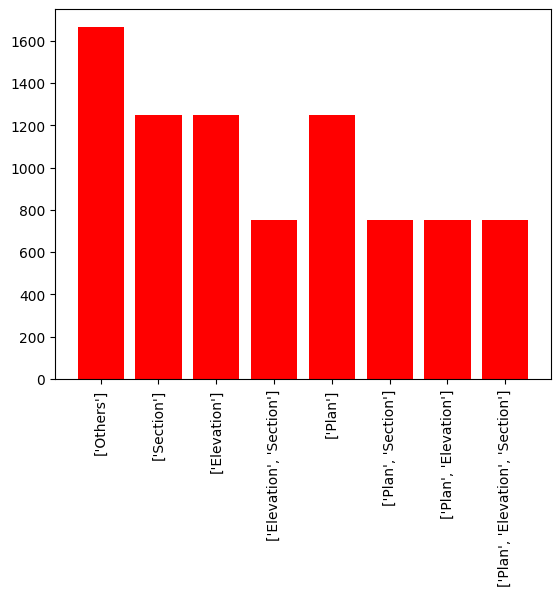

In [ ]:
#Count and plot multiple class
print('Multiple class count, tot',str(y_train.shape[0]))
cnt, unq= count_uniq_rows(y_train )
lab_lst=[]
for u in unq:
  #print(u)
  lab_lst.append(str([b for a, b in zip(u, LABELS) if a]))
# Plotting
plt.bar(lab_lst,cnt,  color='red')
plt.tick_params(axis='x', rotation=90)
plt.savefig(os.path.join(PLOT_FOLDER, '04_After_balance_class_count.png'), dpi=300, bbox_inches='tight')
plt.show()
print('\n')
#-End plot---

In [ ]:
#Split here to augment training and validation
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,  test_size=0.20, random_state=42)

# Model

In [ ]:
#Copy models
!cp -r  '/content/gdrive/MyDrive/Colab Notebooks/ReAD/02_Draw/Models' /content

## Def.

In [ ]:
def define_nn_clf(pretrain_mod= 'res',
                  pretrain_trainable= False,
                  use_rescaling= False,
                  n_layers=1,
                  layer_dim=128,
                  layer_reducer= 2,
                  use_dropout= True,
                  dropout= 0.3,
                  use_norm= False,
                  multi_label=False,
                  activation= 'tanh',
                  opt= 'rmsprop',
                  metrics=['accuracy',f1_m],
                  output_shape= 1,
                  verbose= False):

  # Initialize the Pretrained Model
  if pretrain_mod== 'res':
    feature_extractor = ResNet50(weights='imagenet',
                                input_shape=(224, 224, 3),
                                include_top=False)
  else:
    feature_extractor = VGG16(weights='imagenet',
                                input_shape=(224, 224, 3),
                                include_top=False)

  # Set this parameter to make sure it's not being trained
  feature_extractor.trainable = pretrain_trainable

  # Set the input layer
  input_ = tf.keras.Input(shape=(224, 224, 3))

  # Rescaling
  if use_rescaling:
    x= tf.keras.layers.Rescaling(1./255) (input_)
  else:
    x= input_

  # Set the feature extractor layer
  x = feature_extractor(x , training=pretrain_trainable)

  x = tf.keras.layers.Flatten(name= 'bottleneck')(x)

  # Midle
  dim_reducer=1
  for i in range(1, n_layers+1, 1):
    if use_dropout:
      x = tf.keras.layers.Dropout(dropout/i)(x)
      if verbose: print('+ Dropout_'+str(i),'drop:',str(dropout/i))
    x = tf.keras.layers.Dense(layer_dim//dim_reducer, name='dense_count_'+str(i))(x)
    if verbose: print('+ Dense_'+str(i),'dim:',str(layer_dim//dim_reducer))
    if use_norm:
      x = tf.keras.layers.BatchNormalization()(x)
      if verbose: print('+ BatchNorm')
    x = tf.keras.layers.Activation(activation)(x)
    dim_reducer= i*layer_reducer
    if verbose: print('\n')

  if output_shape==1:
    #Output singolo
    f_act='sigmoid'
    used_loss='binary_crossentropy'
  elif multi_label:
    #Output multi label
    f_act='sigmoid'
    used_loss='binary_crossentropy'
  else:
    #Output multi classe
    f_act='softmax'
    used_loss='categorical_crossentropy'

  x = tf.keras.layers.Dropout(dropout/i)(x)
  output_  = tf.keras.layers.Dense(output_shape, activation=f_act)(x)
  if verbose:
    print('+ Final layer: drop',str(dropout/i),', dim:',str(output_shape))
    print('\nActivation:',f_act,',Loss',used_loss)

  # Create the new model object
  model = tf.keras.Model(input_, output_, name='DrawClassifier')

  model.compile(optimizer=opt,
                loss=used_loss,
                metrics=metrics)
  return model

## All steps

### Train

In [ ]:
print('\nTRAINING')

In [ ]:
STEPS_PER_EPOCH= x_train.shape[0]//BATCH_SIZE
STEPS_VAL= x_val.shape[0]//BATCH_SIZE

In [ ]:
print('BATCH_SIZE', BATCH_SIZE, ',EPOCHS', EPOCHS, ',STEPS_PER_EPOCH', STEPS_PER_EPOCH)

In [ ]:
configs = dict(
    batch_size = BATCH_SIZE,
    learning_rate = 0.001,
    epochs = EPOCHS,
    train_on_all_data= TRAIN_ON_ALL_DATA,
    train_on_train_and_validation= TRAIN_ON_TRAIN_AND_VAL,
    augment_by_class= s_st
)

In [ ]:
clf_NN= define_nn_clf(pretrain_mod= 'vgg',
                      n_layers=2,
                      layer_dim=4096,
                      layer_reducer= 1,
                      use_dropout= True,
                      dropout= 0.7,
                      use_norm= False,
                      activation= 'relu',
                      multi_label= True,
                      opt= SGD(learning_rate= configs['learning_rate']),
                      output_shape= 4,
                      metrics=['accuracy',f1_m],
                      verbose= True)
plot_model(clf_NN, to_file=os.path.join(PLOT_FOLDER, 'model_plot.png'), show_shapes=True, show_layer_names=True)
clf_NN.summary()

In [ ]:
file_name='clf_NN_multi_l.ckp'

checkpoint_filepath=os.path.join(os.getcwd(),'ckpoints', file_name)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1_m',
    mode='max',
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=25, # how many epochs to wait before stopping
    restore_best_weights=True,
)

save_ck_point = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_f1_m',
    mode='max',
    save_best_only=True)

tensorboard = TensorBoard(log_dir='./tb_logs_train', histogram_freq=0,
                          write_graph=True, write_images=False)
#WanDB
run=wandb.init(
              # Set the project where this run will be logged
              project="ReAD",
              # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
              name='Training',
              # Track hyperparameters and run metadata
              config=configs)

In [ ]:
'''
train_gen = Aug_Sequence(x_train, y_train, BATCH_SIZE,  augmentations=seq)
x,y = train_gen.__getitem__(0)
x.shape, y.shape
'''

In [ ]:
# Training data
train_gen = Aug_Sequence(x_train, y_train, BATCH_SIZE,  augmentations=seq)

#Use this to final train on validation and training
#train_gen = Aug_Sequence(np.concatenate((x_train,x_val)), np.concatenate((y_train,y_val)), BATCH_SIZE,  augmentations=seq)

# Training
history=  clf_NN.fit_generator(train_gen,
                                epochs=EPOCHS,
                                validation_data=(x_val, y_val),
                                workers=2,
                                use_multiprocessing=False,
                                shuffle= True,
                                callbacks= [ save_ck_point, WandbMetricsLogger(log_freq=10)] # USE THIS to train and validate [ early_stopping,save_ck_point  ,tensorboard ]
                               )

In [ ]:
# Close the W&B run
run.finish()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(PLOT_FOLDER, '05_Train_accuracy.png'))
plt.show()

In [ ]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('model f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(PLOT_FOLDER, '05_Train_f1.png'))
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(PLOT_FOLDER, '05_Train_loss.png'))
plt.show()

In [ ]:
threshold=0.40
val_pred_NN= clf_NN.predict(x_val)
val_pred_NN= np.where(np.array(val_pred_NN) > threshold, 1, 0 ).astype('int32') #tf.argmax(val_pred_NN, axis=1)

In [ ]:
print('\n Validation')
print("Accuracy:",f1_m(y_val.astype('float32'), val_pred_NN.astype('float32')))

In [ ]:
multilabel_stat(y_val, val_pred_NN, labels=LABELS)

In [ ]:
file_name='clf_NN_multi_l.h5'
file_path= os.path.join(os.getcwd(),MODELS_FOLDER,file_name)

clf_NN.save_weights(file_path)

### Fine tuning

In [ ]:
print('\nFINE TUNE')

In [ ]:
configs = dict(
    batch_size = BATCH_SIZE,
    learning_rate = 1e-5,
    epochs = EPOCHS,
    train_on_all_data= TRAIN_ON_ALL_DATA,
    train_on_train_and_validation= TRAIN_ON_TRAIN_AND_VAL,
    augment_by_class= s_st
)

In [ ]:
clf_NN= define_nn_clf(pretrain_mod= 'vgg',
                      pretrain_trainable= True,
                      n_layers=2,
                      layer_dim=4096,
                      layer_reducer= 1,
                      use_dropout= True,
                      dropout= 0.7,
                      use_norm= False,
                      activation= 'relu',
                      multi_label= True,
                      opt= SGD(lr = configs['learning_rate']),
                      output_shape= 4,
                      metrics=['accuracy',f1_m],
                      verbose= True)

#Load weights
file_name='clf_NN_multi_l.h5'
file_path= os.path.join(os.getcwd(),MODELS_FOLDER,file_name)
clf_NN.load_weights(file_path)

#Summary
clf_NN.summary()

In [ ]:
file_name='clf_NN_multi_2.ckp'

checkpoint_filepath=os.path.join(os.getcwd(),'ckpoints', file_name)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1_m',
    mode='max',
    min_delta=0.0001,  # minimium amount of change to count as an improvement
    patience=11,      # how many epochs to wait before stopping
    restore_best_weights=True,
)

save_ck_point = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_f1_m',
    mode='max',
    save_best_only=True)

tensorboard = TensorBoard(log_dir='./tb_logs_tune', histogram_freq=0,
                          write_graph=True, write_images=False)

#WanDB
run=wandb.init(
              # Set the project where this run will be logged
              project="ReAD",
              # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
              name='Tuning',
              # Track hyperparameters and run metadata
              config=configs)

In [ ]:
# Training data
train_gen = Aug_Sequence(x_train, y_train, BATCH_SIZE,  augmentations=seq)

#Use this to final train on validation and training
#train_gen = Aug_Sequence(np.concatenate((x_train,x_val)), np.concatenate((y_train,y_val)), BATCH_SIZE,  augmentations=seq)

# Training
history=  clf_NN.fit_generator(train_gen,
                              epochs=EPOCHS,
                              validation_data=(x_val, y_val),
                              workers=2,
                              use_multiprocessing=False,
                              shuffle=True,
                              callbacks= [ save_ck_point,  early_stopping, WandbMetricsLogger(log_freq=10)]   #USE THIS to train and validate [ early_stopping,save_ck_point, tensorboard,]
                               )

In [ ]:
# Close the W&B run
run.finish()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(PLOT_FOLDER, '06_Tune_accuracy.png'))
plt.show()

In [ ]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('model f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(PLOT_FOLDER, '06_Tune_f1.png'))
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(PLOT_FOLDER, '06_Tune_loss.png'))
plt.show()

In [ ]:
threshold=0.40
val_pred_NN= clf_NN.predict(x_val)
val_pred_NN= np.where(np.array(val_pred_NN) > threshold, 1, 0 ).astype('int32') #tf.argmax(val_pred_NN, axis=1)

In [ ]:
# Model Accuracy, how often is the classifier correct?
#print("Accuracy:",metrics.accuracy_score(y_val, val_pred_NN))
print('\n Validation')
print("Accuracy:",f1_m(y_val.astype('float32'), val_pred_NN.astype('float32')))

In [ ]:
multilabel_stat(y_val, val_pred_NN, labels=LABELS)

In [ ]:
file_name='clf_NN_multi_2.h5'
file_path= os.path.join(os.getcwd(),MODELS_FOLDER,file_name)

clf_NN.save_weights(file_path)

### Threshold optimization
[Documentation](https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/)

In [ ]:
#Load model
clf_NN= define_nn_clf(pretrain_mod= 'vgg',
                      pretrain_trainable= False,
                      n_layers=2,
                      layer_dim=4096,
                      layer_reducer= 1,
                      use_dropout= True,
                      dropout= 0.7,
                      use_norm= False,
                      activation= 'relu',
                      multi_label= True,
                      opt= SGD(lr = 1e-5),
                      output_shape= 4,
                      metrics=['accuracy',f1_m],
                      verbose= True)

#Load weights
file_name='clf_NN_multi_2.h5'
file_path= os.path.join(os.getcwd(),MODELS_FOLDER,file_name)
clf_NN.load_weights(file_path)

#Summary
clf_NN.summary()

+ Dropout_1 drop: 0.7
+ Dense_1 dim: 4096


+ Dropout_2 drop: 0.35
+ Dense_2 dim: 4096


+ Final layer: drop 0.35 , dim: 4

Activation: sigmoid ,Loss binary_crossentropy
Model: "DrawClassifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 bottleneck (Flatten)        (None, 25088)             0         
                                                                 
 dropout_3 (Dropout)         (None, 25088)             0         
                                                                 
 dense_count_1 (Dense)       (None, 4096)              102764544 
                                                                 
 activation_2 

In [ ]:
# predict probabilities
y_pred = clf_NN.predict(x_train)

168/168 [==============================] - 23s 139ms/step


**Optimal Threshold for ROC Curve**<BR>
A ROC curve is a diagnostic plot that evaluates a set of probability predictions made by a model on a test dataset.<BR>
<BR>
A set of different thresholds are used to interpret the true positive rate and the false positive rate of the predictions on the positive (minority) class, and the scores are plotted in a line of increasing thresholds to create a curve.

Optimal Threshold for ROC Curve
Plan - Best Threshold=0.432679, G-Mean=0.862


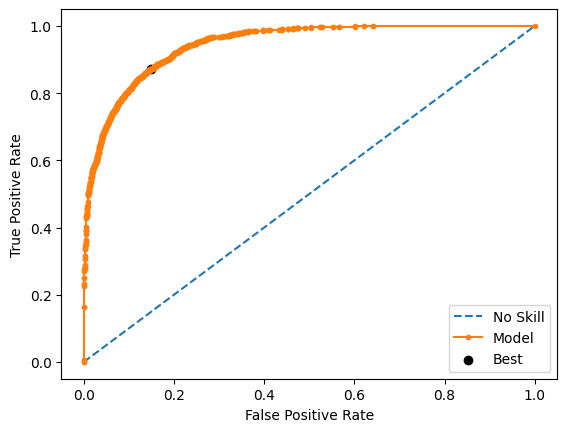

Elevation - Best Threshold=0.390177, G-Mean=0.855


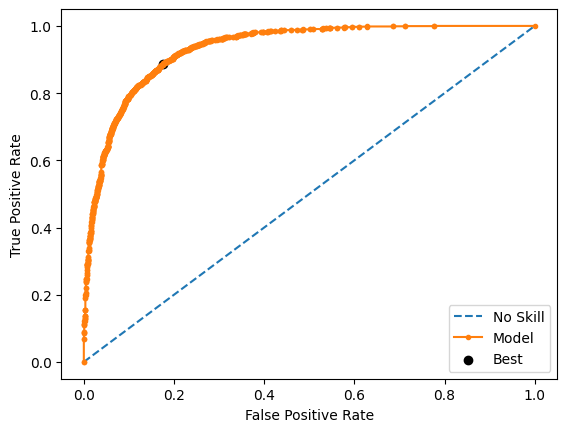

Section - Best Threshold=0.437827, G-Mean=0.823


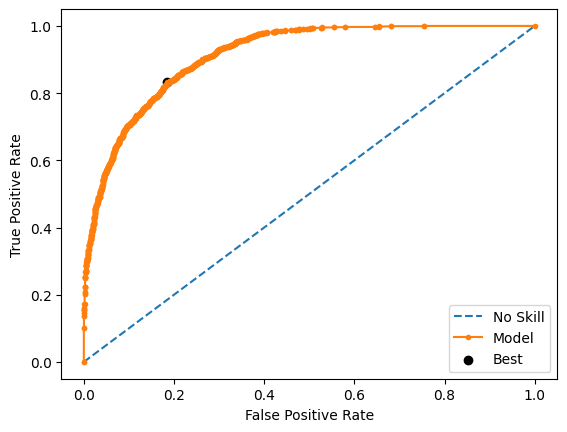

Others - Best Threshold=0.357138, G-Mean=0.927


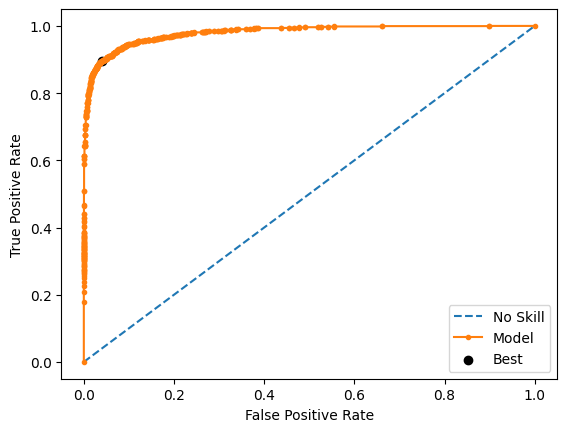

Threshols for g-mean optimization:
 [{'label': 'Plan', 'thr': 0.43267885, 'g-mean': 0.8619700035980267}, {'label': 'Elevation', 'thr': 0.39017668, 'g-mean': 0.8553740092789465}, {'label': 'Section', 'thr': 0.43782702, 'g-mean': 0.8232501638878289}, {'label': 'Others', 'thr': 0.35713845, 'g-mean': 0.9274623244555951}]


In [ ]:
#_ = opt_ROC_thresholds(y_train,y_pred,labels=LABELS)

**Optimal Threshold for Precision-Recall Curve**<br>
Unlike the ROC Curve, a precision-recall curve focuses on the performance of a classifier on the positive (minority class) only.<br>
<br>
Precision is the ratio of the number of true positives divided by the sum of the true positives and false positives. It describes how good a model is at predicting the positive class. Recall is calculated as the ratio of the number of true positives divided by the sum of the true positives and the false negatives. Recall is the same as sensitivity.


OPTIMIZING thresholds...
Optimal Threshold for Precision-Recall Curve
Plan - Best Threshold=0.483, F-Score=0.797


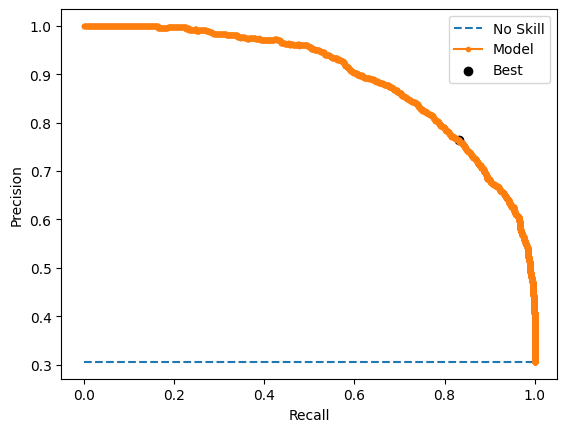

Elevation - Best Threshold=0.468, F-Score=0.802


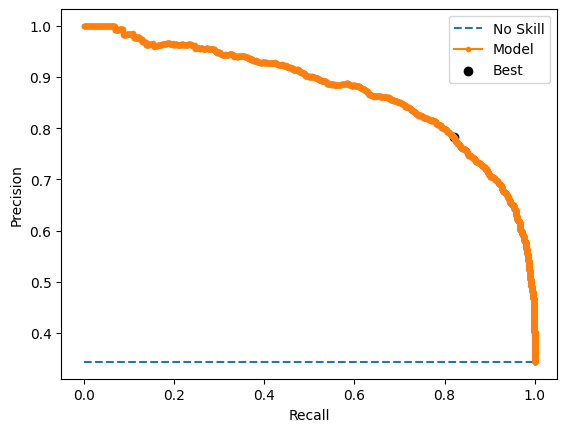

Section - Best Threshold=0.531, F-Score=0.706


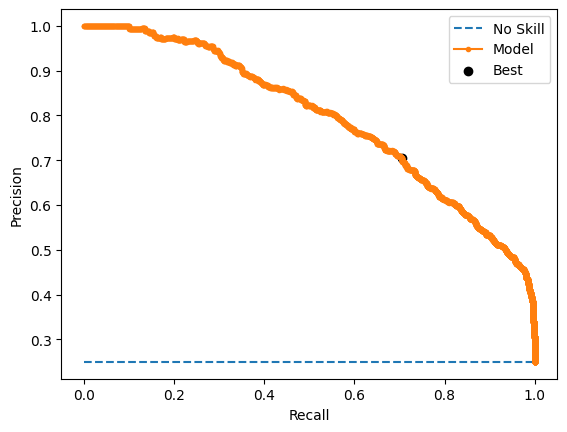

Others - Best Threshold=0.371, F-Score=0.910


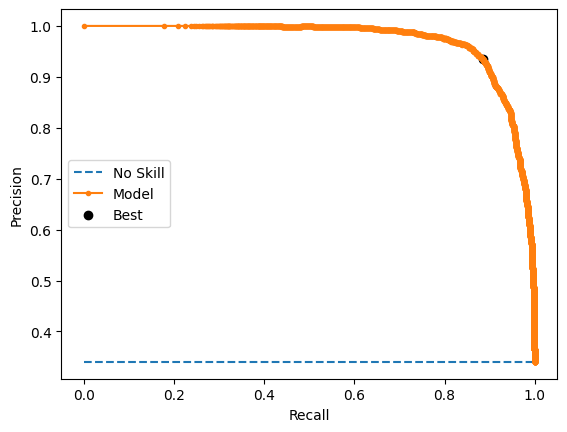

Threshols for f1 optimization:
 [{'label': 'Plan', 'thr': 0.4826066, 'f1-score': 0.7968430283542823}, {'label': 'Elevation', 'thr': 0.46782795, 'f1-score': 0.8015915119363395}, {'label': 'Section', 'thr': 0.5310487, 'f1-score': 0.7055306427503737}, {'label': 'Others', 'thr': 0.37144834, 'f1-score': 0.9099606077658976}]
Saving thresholds to file...
Done


In [ ]:
if OPTIMIZE_THRESHOLDS:
  print('OPTIMIZING thresholds...')
  thresholds= opt_PRC_thresholds(y_train,y_pred,labels=LABELS)  #opt_f1_thresholds(y_train,y_pred,labels=LABELS)
  if SAVE_THRESHOLDS:
    #Save to file
    print('Saving thresholds to file...')
    with open(os.path.join(MODELS_FOLDER, THRESHOLD_FILE) , 'wb') as v_file:
      pickle.dump(thresholds,v_file)
    print('Done')
  else:
    print('Thresholds not saved.')
else:
  _= opt_PRC_thresholds(y_train,y_pred,labels=LABELS)

### Grafico distribuzione Training set
Serve per rendersi conto delle soglie che verranno calcolate.

In [ ]:
#Restore original dataset (not augmented) because file list are not augmented
#Save original dataset
x_train = x_train_orig
y_train = y_train_orig
train_img_file_list= train_img_file_list_orig

#JOIN data
x_train = np.vstack((x_train, x_val))
y_train = np.vstack((y_train, y_val))
train_img_file_list =train_img_file_list+val_img_file_list

In [ ]:
y_pred= clf_NN.predict(x_train)

168/168 [==============================] - 23s 139ms/step


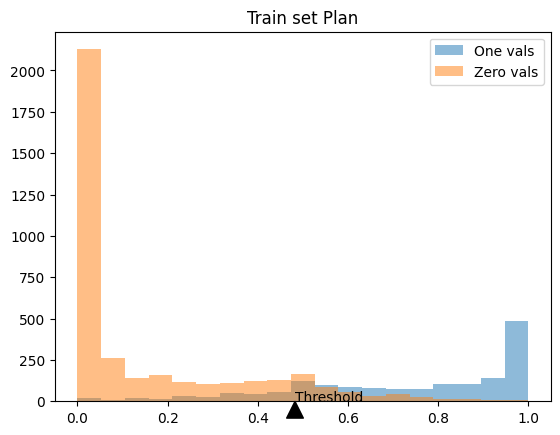

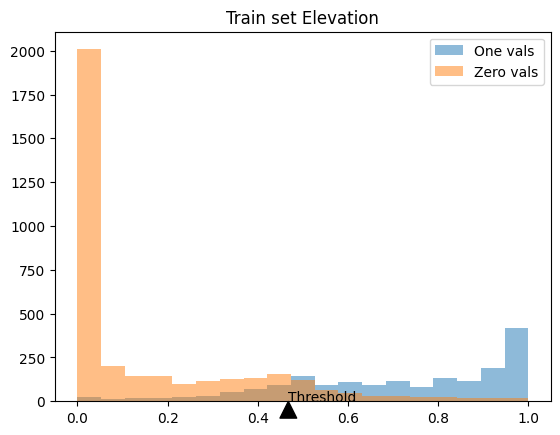

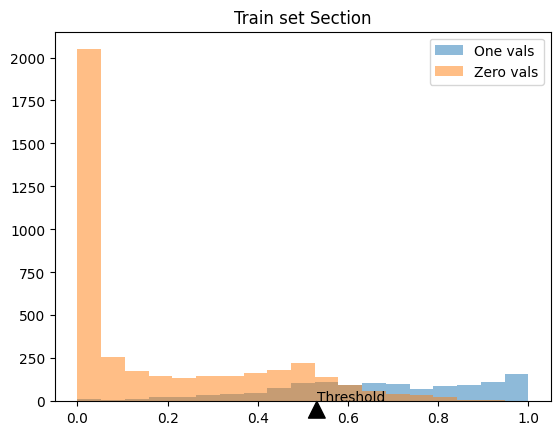

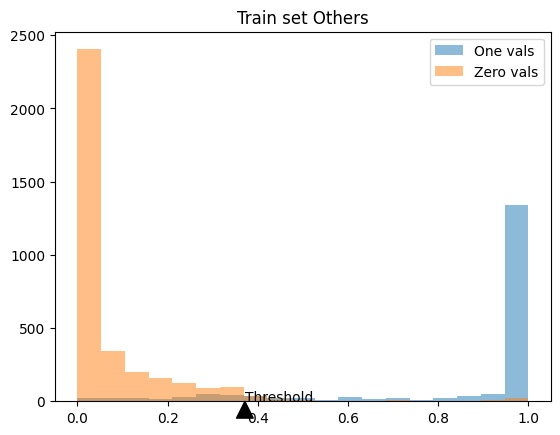

In [ ]:
plot_pred_distr(y_pred, y_train, labels=LABELS, n_beans= 20, title='Train set ', thresholds=thresholds)

### Test on Test set

In [ ]:
print('\nTEST')


TEST


In [ ]:
clf_NN= define_nn_clf(pretrain_mod= 'vgg',
                      pretrain_trainable= False,
                      n_layers=2,
                      layer_dim=4096,
                      layer_reducer= 1,
                      use_dropout= True,
                      dropout= 0.7,
                      use_norm= False,
                      activation= 'relu',
                      multi_label= True,
                      opt= SGD(lr = 1e-5),
                      output_shape= 4,
                      metrics=['accuracy',f1_m],
                      verbose= True)

#Load weights
file_name='clf_NN_multi_2.h5'
file_path= os.path.join(os.getcwd(),MODELS_FOLDER,file_name)
clf_NN.load_weights(file_path)

#Load thresholds
try:
  print('\nLoading threshold file...')
  with open(os.path.join(MODELS_FOLDER, THRESHOLD_FILE) , 'rb') as v_file:
     thresholds= pickle.load(v_file)
     print('Thresholds', thresholds)
  print('Done.\n')

except:
  print('File',os.path.join(MODELS_FOLDER, THRESHOLD_FILE),'not found.')
  thresholds= [{'label': 'Plan',
                'thr': 0.5},
               {'label': 'Elevation',
                'thr': 0.5},
               {'label': 'Section',
                'thr': 0.5},
               {'label': 'Others',
                 'thr': 0.5}]

#Summary
clf_NN.summary()

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


58889256/58889256 [==============================] - 3s 0us/step
+ Dropout_1 drop: 0.7
+ Dense_1 dim: 4096


+ Dropout_2 drop: 0.35
+ Dense_2 dim: 4096


+ Final layer: drop 0.35 , dim: 4

Activation: sigmoid ,Loss binary_crossentropy

Loading threshold file...
Thresholds [{'label': 'Plan', 'thr': 0.4826066, 'f1-score': 0.7968430283542823}, {'label': 'Elevation', 'thr': 0.46782795, 'f1-score': 0.8015915119363395}, {'label': 'Section', 'thr': 0.5310487, 'f1-score': 0.7055306427503737}, {'label': 'Others', 'thr': 0.37144834, 'f1-score': 0.9099606077658976}]
Done.

Model: "DrawClassifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 bottleneck

In [ ]:
x_test, y_test= np.stack(test_ds['X'].to_list()), np.stack(test_ds['y'].to_list())

In [ ]:
threshold=0.5
print('Using fixed threshold to ',str(threshold))
y_pred, level= predict_thresholds(clf_NN, x_test)   #Default thresholds set to 0.5

Using fixed threshold to  0.5
33/33 [==============================] - 20s 219ms/step


Il binary f1 score considera solo 0,1 come possibili output ovvero [1,1,0,0] che rappresenta le label di un solo disegno viene considerato come 4 output distinti.

In [ ]:
f1_s= sklearn.metrics.f1_score(y_test, y_pred, average='weighted')
print('BINARY F1 on test',f1_s,'\n')

BINARY F1 on test 0.7694967311450817 



In [ ]:
print('NOT Optimized threshold')
multilabel_stat(y_test,y_pred,labels=LABELS, display_plot= False)

NOT Optimized threshold
Multiclass report
                                  precision    recall  f1-score   support

                      ['Others']       0.95      0.79      0.86       338
                     ['Section']       0.56      0.79      0.66       150
                   ['Elevation']       0.60      0.64      0.62       188
        ['Elevation', 'Section']       0.42      0.30      0.35        47
                        ['Plan']       0.71      0.73      0.72       180
             ['Plan', 'Section']       0.37      0.46      0.41        41
           ['Plan', 'Elevation']       0.59      0.26      0.36        73
['Plan', 'Elevation', 'Section']       0.26      0.41      0.32        29

                        accuracy                           0.67      1046
                       macro avg       0.56      0.55      0.54      1046
                    weighted avg       0.70      0.67      0.67      1046



In [ ]:
#thresholds[3]['thr']=0.4
#thresholds

In [ ]:
#Predizione in forma binaria e livello di certezza
y_pred, level= predict_thresholds(clf_NN, x_test, thresholds)

Using optimized thresholds
33/33 [==============================] - 4s 133ms/step


Il binary f1 score considera solo 0,1 come possibili output ovvero [1,1,0,0] che rappresenta le label di un solo disegno viene considerato come 4 output distinti.

In [ ]:
f1_s= sklearn.metrics.f1_score(y_test, y_pred, average='micro')
print('BINARY F1 on test (opt. thresholds):',f1_s,'\n')

BINARY F1 on test (opt. thresholds): 0.7782131661442006 



In [ ]:
print('Optimized threshold')
multilabel_stat(y_test,y_pred,labels=LABELS, display_plot= False)

Optimized threshold
Multiclass report
                                  precision    recall  f1-score   support

                      ['Others']       0.95      0.81      0.87       338
                     ['Section']       0.61      0.77      0.68       150
                   ['Elevation']       0.62      0.65      0.64       188
        ['Elevation', 'Section']       0.38      0.28      0.32        47
                        ['Plan']       0.77      0.72      0.74       180
             ['Plan', 'Section']       0.51      0.44      0.47        41
           ['Plan', 'Elevation']       0.32      0.32      0.32        73
['Plan', 'Elevation', 'Section']       0.29      0.41      0.34        29

                       micro avg       0.69      0.68      0.68      1046
                       macro avg       0.56      0.55      0.55      1046
                    weighted avg       0.70      0.68      0.69      1046



Test single class: Plan
One vs Others on validation set


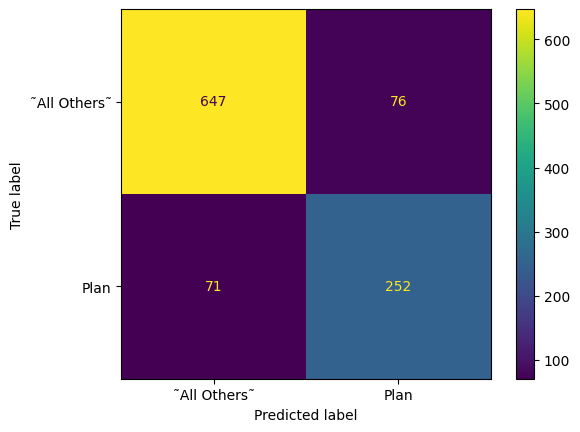


Classification Report
              precision    recall  f1-score   support

˜All Others˜       0.90      0.89      0.90       723
        Plan       0.77      0.78      0.77       323

    accuracy                           0.86      1046
   macro avg       0.83      0.84      0.84      1046
weighted avg       0.86      0.86      0.86      1046

Test single class: Elevation
One vs Others on validation set


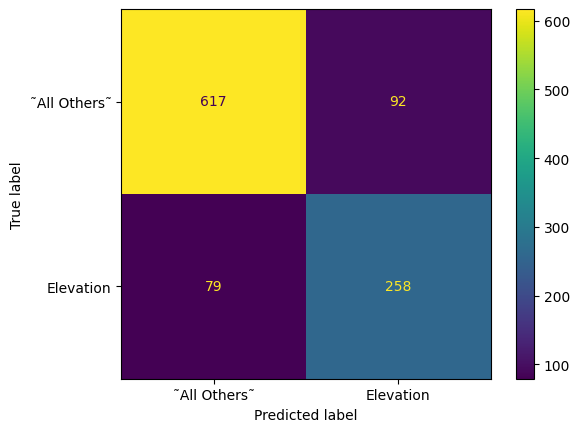


Classification Report
              precision    recall  f1-score   support

˜All Others˜       0.89      0.87      0.88       709
   Elevation       0.74      0.77      0.75       337

    accuracy                           0.84      1046
   macro avg       0.81      0.82      0.81      1046
weighted avg       0.84      0.84      0.84      1046

Test single class: Section
One vs Others on validation set


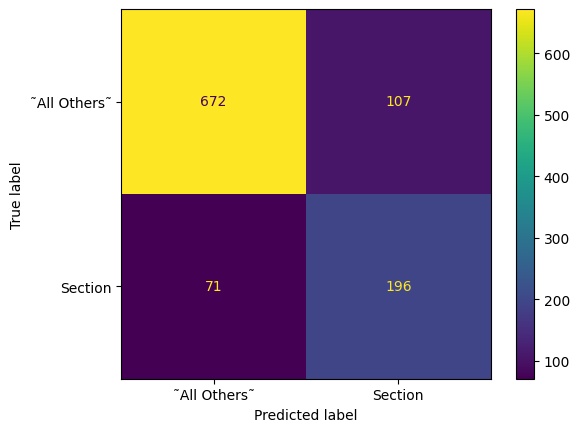


Classification Report
              precision    recall  f1-score   support

˜All Others˜       0.90      0.86      0.88       779
     Section       0.65      0.73      0.69       267

    accuracy                           0.83      1046
   macro avg       0.78      0.80      0.79      1046
weighted avg       0.84      0.83      0.83      1046

Test single class: Others
One vs Others on validation set


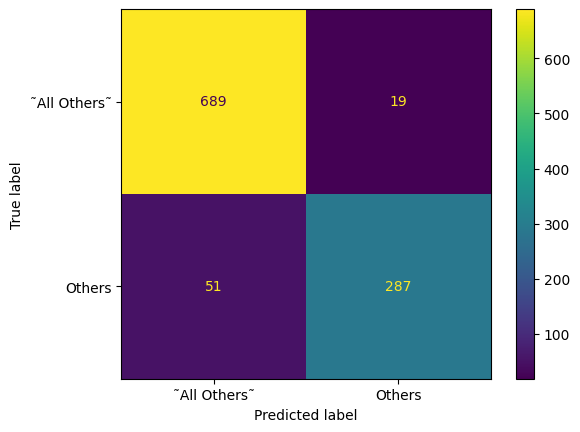


Classification Report
              precision    recall  f1-score   support

˜All Others˜       0.93      0.97      0.95       708
      Others       0.94      0.85      0.89       338

    accuracy                           0.93      1046
   macro avg       0.93      0.91      0.92      1046
weighted avg       0.93      0.93      0.93      1046



In [ ]:
for ind, _ in enumerate(LABELS):
  #From multi label to binary
  print('Test single class:',LABELS[ind])

  # Normal
  print('One vs Others on validation set')
  cm = confusion_matrix(y_test[:,ind], y_pred[:,ind])
  #print(cm)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['˜All Others˜',LABELS[ind]])
  disp.plot()

  plt.savefig('normal.png')
  plt.savefig(os.path.join(PLOT_FOLDER, '07_Test'+str(ind)+'_binary.png'))
  plt.show()

  print('\nClassification Report')
  print(classification_report(y_test[:,ind], y_pred[:,ind], target_names=['˜All Others˜',LABELS[ind]]))

In [ ]:
multi_lab_idx= np.argwhere(np.sum(y_pred, axis=1) > 1)
multi_lab_idx= np.ravel(multi_lab_idx)
print('Num of multilabel img predicted', len(multi_lab_idx))

Num of multilabel img predicted 197


In [ ]:
multi_lab_idx= np.argwhere(np.sum(y_test, axis=1) > 1)
multi_lab_idx= np.ravel(multi_lab_idx)
print('Num of multilabel img on test set', len(multi_lab_idx))

Num of multilabel img on test set 190


In [ ]:
print(LABELS)

header= 'ID;File;Real;Predicted,sure level\n'
print(header)

with open('result_01.csv', 'w') as f:
    #writer=csv.writer(f, delimiter='', lineterminator='\n')
    f.write(header)

    count=0
    for idx in range(len(y_pred)):
      if not(np.array_equal(y_pred[idx],y_test[idx])):
        row= str(idx)+';'+ test_img_file_list[idx].split('/')[-1].strip() \
              +';'+ str(np.array(LABELS)[y_test[idx].astype(bool)].tolist()) \
              +';'+ str(np.array(LABELS)[y_pred[idx].astype(bool)].tolist())
              #',real', y_test[idx], ',',np.array(LABELS)[y_test[idx].astype(bool)].tolist(),
              #',pred', y_pred[idx], ',',np.array(LABELS)[y_pred[idx].astype(bool)].tolist())
        if level[idx]==0:
          row=row+(';<-- not sure')
        else:
          row=row+(';regular')
        print(row)
        f.write(row+'\n')
        count+=1

print('Tot errate',count,'su',len(y_pred),'(',round(count/len(y_pred),3),')')

['Plan', 'Elevation', 'Section', 'Others']
ID;File;Real;Predicted,sure level

2;iccd8311321sa099767.jpg;['Elevation', 'Section'];['Plan', 'Elevation', 'Section']
5;iccd11163690politoprm0100.jpg;['Plan', 'Elevation'];['Section']<-- not sure
8;iccd11181230politoprm0147.jpg;['Elevation'];['Plan', 'Elevation']
11;iccd3222009lb047613.jpg;['Plan', 'Elevation'];['Section']
18;iccd12332810unipmndsudig00045.jpg;['Elevation'];['Others']
20;iccd11176798politoprm0452.jpg;['Elevation'];['Plan', 'Elevation']
22;iccd5515429g0211424.jpg;['Others'];['Plan', 'Elevation', 'Others']
24;iccd3726136ads1081.jpg;['Others'];['Elevation']
26;iccd292817172318h.jpg;['Elevation', 'Section'];['Elevation']
27;iccd2931434crbc045123xc.jpg;['Others'];['Elevation', 'Section']
34;iccd13945182fasc1437489.jpg;['Elevation'];['Plan', 'Section']
35;iccd13945699fasc1437502_0.jpg;['Plan', 'Elevation', 'Section'];['Elevation', 'Section']
36;iccd6839054mc006559.jpg;['Plan'];['Others']
37;iccd3220420sb083869.jpg;['Elevation'];['Pl

### Grafico distribuzione Test set

In [ ]:
x_test, y_test= np.stack(test_ds['X'].to_list()), np.stack(test_ds['y'].to_list())
y_pred= clf_NN.predict(x_test)

33/33 [==============================] - 4s 139ms/step


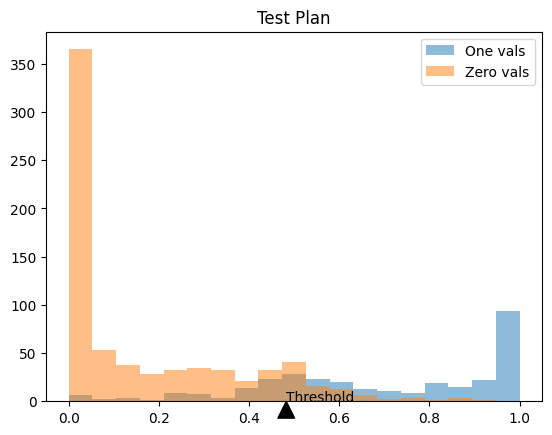

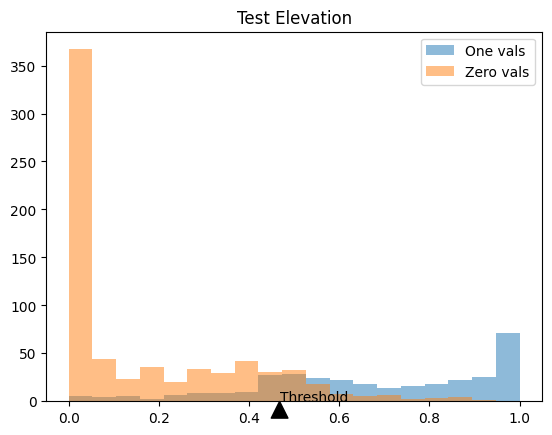

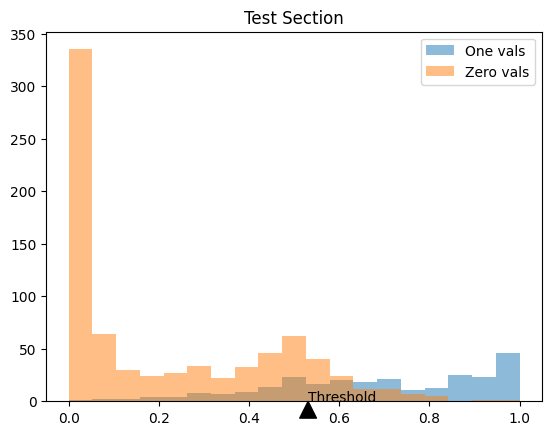

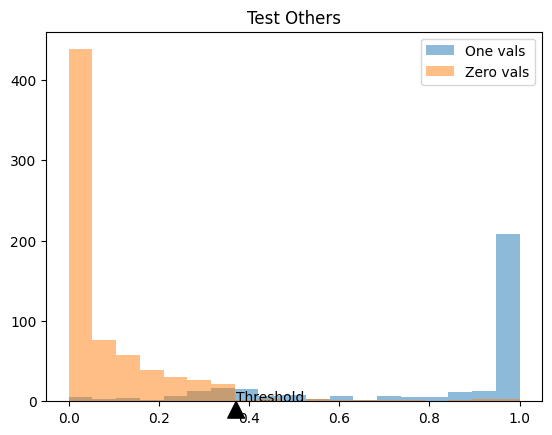

In [ ]:
plot_pred_distr(y_pred, y_test, labels=LABELS, n_beans= 20, title='Test ', thresholds=thresholds)

### Test on training+validation

In [ ]:
print('\nTEST (on training+validation)')


TEST (on training+validation)


In [ ]:
#Restore original dataset (not augmented) because file list are not augmented
#Save original dataset
x_train = x_train_orig
y_train = y_train_orig
train_img_file_list= train_img_file_list_orig

#JOIN data
x_train = np.vstack((x_train, x_val))
y_train = np.vstack((y_train, y_val))
train_img_file_list =train_img_file_list+val_img_file_list

#Predizione in forma binaria e livello di certezza
y_pred, level= predict_thresholds(clf_NN, x_train, thresholds)

Using optimized thresholds
168/168 [==============================] - 24s 143ms/step


In [ ]:
print(LABELS)

header= 'ID;Folder;File;Real;Predicted\n'
print(header)

with open('result_train_01.csv', 'w') as f:
    #writer=csv.writer(f, delimiter='', lineterminator='\n')
    f.write(header)

    count=0
    for idx in range(len(y_pred)):
      if not(np.array_equal(y_pred[idx],y_train[idx])):
        row= str(idx)+';'+ train_img_file_list[idx].split('/')[-2].strip() \
              +';'+train_img_file_list[idx].split('/')[-1].strip() \
              +';'+ str(np.array(LABELS)[y_train[idx].astype(bool)].tolist()) \
              +';'+ str(np.array(LABELS)[y_pred[idx].astype(bool)].tolist())
              #',real', y_test[idx], ',',np.array(LABELS)[y_test[idx].astype(bool)].tolist(),
              #',pred', y_pred[idx], ',',np.array(LABELS)[y_pred[idx].astype(bool)].tolist())
        if level[idx]==0:
          row=row+(';<-- not sure')
        else:
          row=row+(';regular')

        print(row)
        f.write(row+'\n')
        count+=1

print('Tot errate',count,'su',len(y_pred),'(',round(count/len(y_pred),3),')')

['Plan', 'Elevation', 'Section', 'Others']
ID;Folder;File;Real;Predicted

3;All;iccd551143200030030.jpg;['Plan'];['Plan', 'Others'];regular
5;All;iccd13369548fscmo3591.jpg;['Elevation'];['Plan', 'Elevation', 'Section'];regular
9;All;iccd3222696s0205914.jpg;['Elevation'];['Elevation', 'Section'];regular
12;All;iccd5354628159919.jpg;['Plan', 'Elevation'];['Elevation'];regular
18;All;iccd142159169913154foto.jpg;['Elevation'];['Plan'];regular
27;All;iccd8349761g0213729.jpg;['Plan', 'Elevation', 'Section'];['Elevation', 'Section'];regular
35;All;iccd292862672551h.jpg;['Plan', 'Elevation'];['Others'];regular
36;All;iccd5758410ftan41494.jpg;['Plan', 'Section'];['Plan', 'Elevation', 'Section'];regular
37;All;iccd11169013politoprm0378.jpg;['Elevation'];['Plan', 'Section'];regular
40;All;iccd11263128politoprm0310bis.jpg;['Plan', 'Elevation'];['Elevation'];regular
41;All;iccd107272512668r.jpg;['Elevation'];['Plan', 'Section'];regular
42;All;iccd14528381302873.jpg;['Plan', 'Elevation'];['Elevation

In [ ]:
# SAVE Model
# ==========

'''
file_name='clf_NN_multi.h5'
file_path= os.path.join(os.getcwd(),MODELS_FOLDER,file_name)

clf_NN.save_weights(file_path)
'''

"\nfile_name='clf_NN_multi.h5'\nfile_path= os.path.join(os.getcwd(),MODELS_FOLDER,file_name)\n\nclf_NN.save_weights(file_path)\n"

# Copy models

In [ ]:
#!cp -r /content/Models 'your Google Drive folder'